In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
from dashboard_app._format_utils import format_price_short, format_number_short, format_number, format_date, format_price, format_volume, format_percent
from dashboard_app._chart_utils import chart_colors, get_chart_color

# Set global figure size and DPI
# Set figure size optimized for A4 (297mm x 210mm at 300dpi)
plt.rcParams['figure.figsize'] = (10, 7)  # Adjusted for better A4 fit
plt.rcParams['figure.dpi'] = 300

# Configure fonts
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 11  # Base font size
plt.rcParams['font.weight'] = 'normal'

# grid lines subtle thin
plt.rcParams['grid.color'] = '#d9d9d9'
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.linewidth'] = 0.5

# grid face light gray
# plt.rcParams['axes.facecolor'] = '#f9fafb'
plt.rcParams['axes.facecolor'] = '#FFFFFF'

# top and right spines off
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

# spines light gray thin
plt.rcParams['axes.edgecolor'] = '#d9d9d9'
plt.rcParams['axes.linewidth'] = 0.5


# Function to format event datetime
def format_event_datetime(dt, include_time=True):
	"""Format datetime to event-relative format (Day 1, Day 2, Day 3)"""
	if isinstance(dt, str):
		dt = pd.to_datetime(dt)

	event_days = {
		pd.Timestamp('2024-07-04').date(): 'Day 1',
		pd.Timestamp('2024-07-05').date(): 'Day 2',
		pd.Timestamp('2024-07-06').date(): 'Day 3'
	}

	date_only = dt.date()
	day_label = event_days.get(date_only, 'Day 1')  # Default to Day 1 instead of Unknown Day

	if include_time:
		return f"{day_label} {dt.strftime('%H:00')}"  # Changed to show only hour
	return day_label


# Function to load data from CSV or DataFrame
def load_data(data_source):
	if isinstance(data_source, str):
		# Load data from CSV file
		data = pd.read_csv(f"./thesis/results/{data_source}")
	else:
		# Assume data_source is a DataFrame
		data = data_source
	return data


# Function to create subplots with consistent formatting
def create_subplots(nrows=1, ncols=1, figsize=(10, 6), sharex=False, sharey=False):
	fig, axes = plt.subplots(nrows, ncols, figsize=figsize, sharex=sharex, sharey=sharey)

	if nrows * ncols > 1:
		for ax in axes.flat:
			ax.tick_params(axis='both', which='major', labelsize=10)
			ax.tick_params(axis='both', which='minor', labelsize=8)
	else:
		axes.tick_params(axis='both', which='major', labelsize=10)
		axes.tick_params(axis='both', which='minor', labelsize=8)

	return fig, axes


# Function to format x-labels as event datetime
def format_xaxis_event_datetime(ax, include_time=True):
	ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: format_event_datetime(pd.to_datetime(x), include_time)))
	plt.xticks(rotation=45, ha='right')


# Function to add reference line to plot
def add_reference_line(ax, x=None, y=None, color='gray', linestyle='--', linewidth=1, label=None):
	if x is not None:
		ax.axvline(x, color=color, linestyle=linestyle, linewidth=linewidth, label=label)
	elif y is not None:
		ax.axhline(y, color=color, linestyle=linestyle, linewidth=linewidth, label=label)


# Function to save chart with consistent formatting
def save_chart(p, filename, dpi=300, bbox_inches='tight', pad_inches=0.1):
	p.savefig(f"./thesis/results/{filename}", dpi=dpi, bbox_inches=bbox_inches, pad_inches=pad_inches)

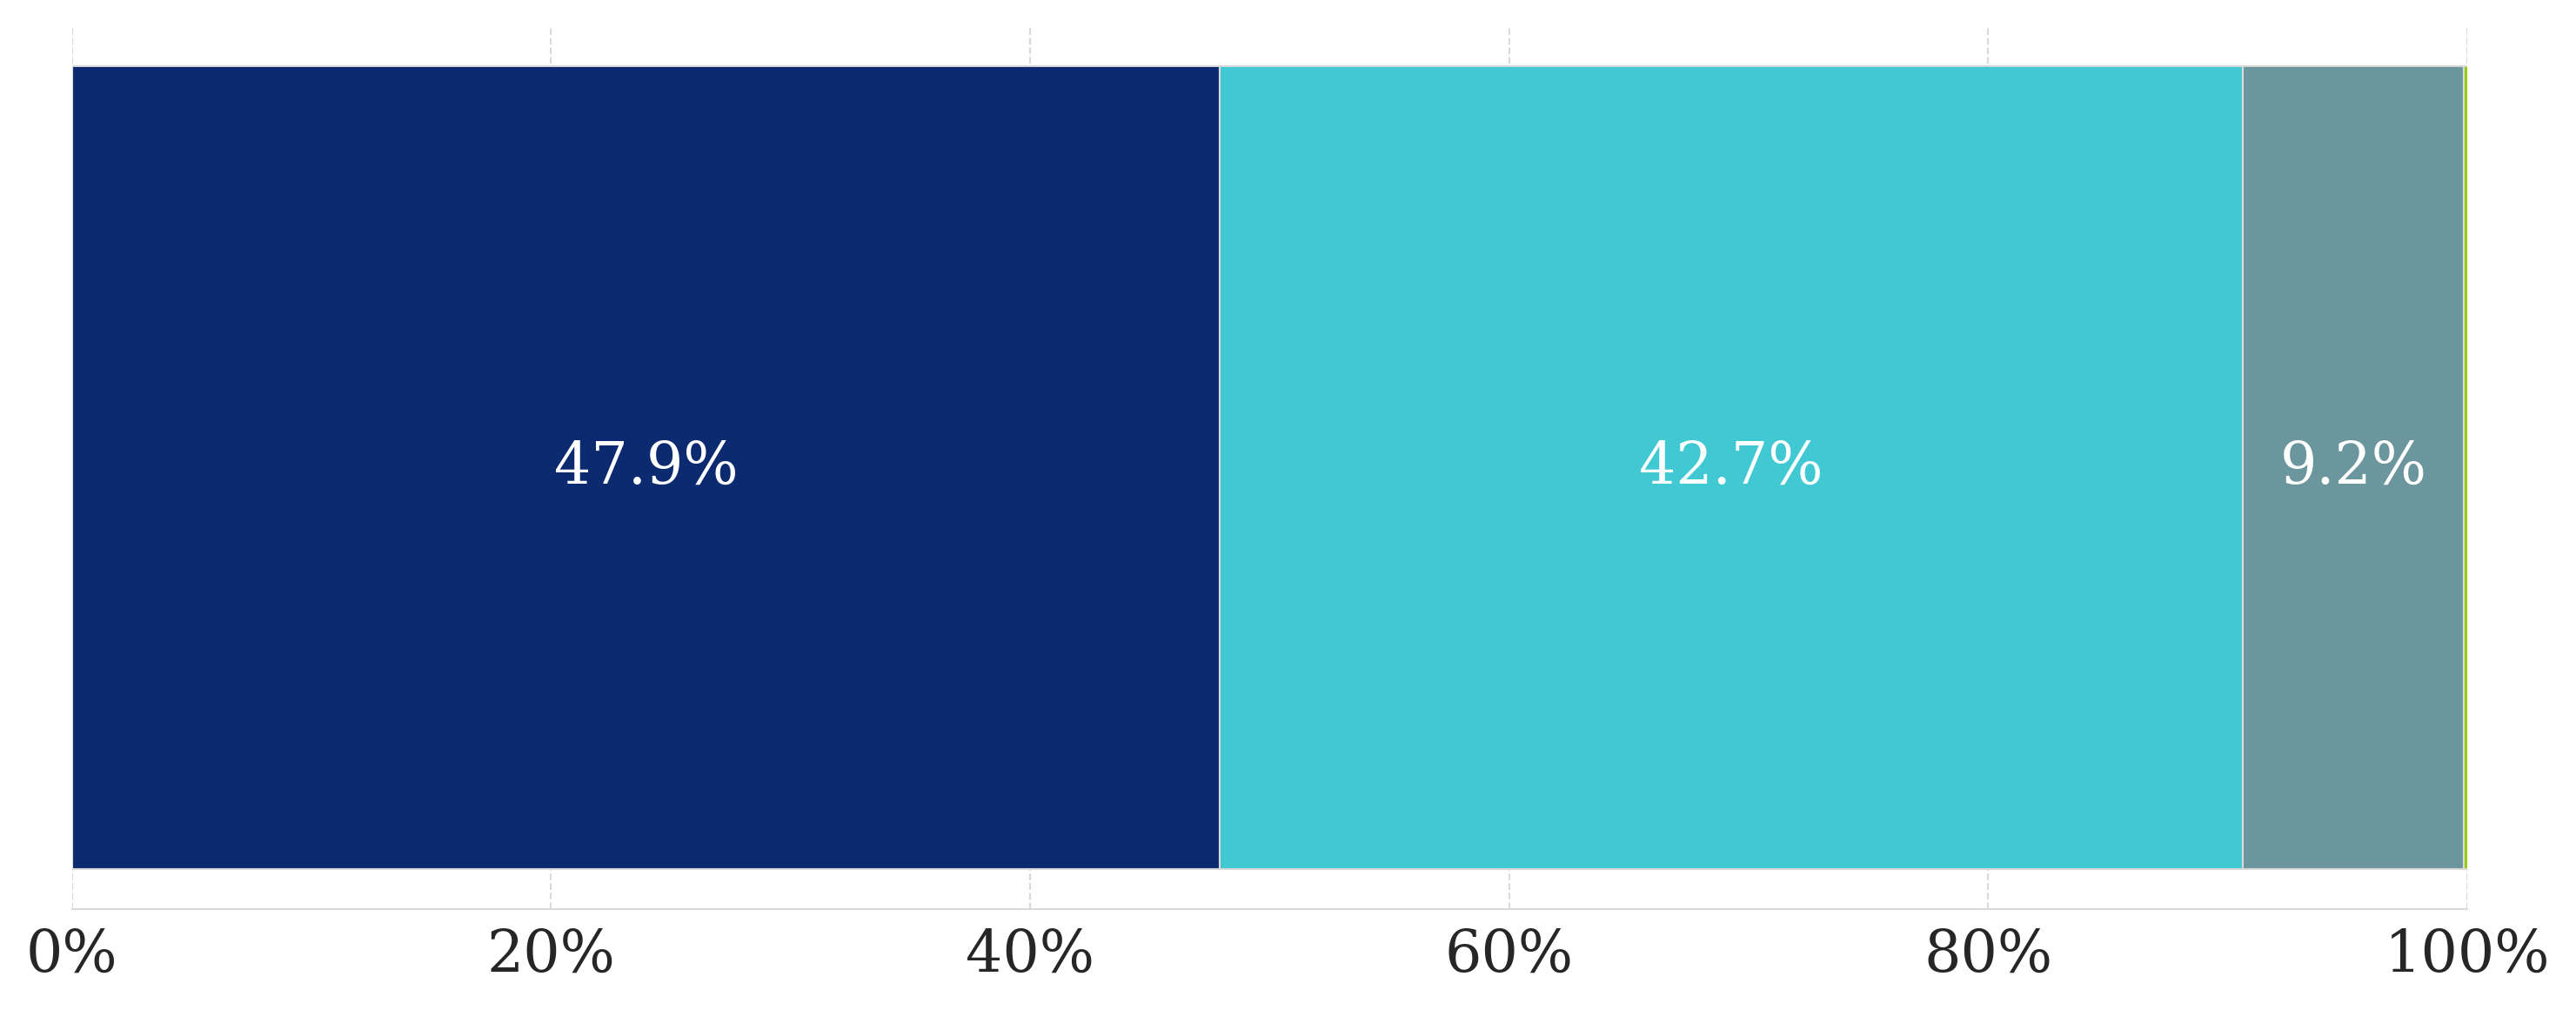

In [218]:
# Data from the pie chart
data = {
	"Payment Method": ["Card terminal", "Cash", "Online pre top-up", "VIP issued"],
	"Count": [8486, 7561, 1634, 23],
	"Total Value (CZK)": [7264503, 5782570, 1436400, 37500]
}

# Convert data to a DataFrame
df = pd.DataFrame(data)

# Calculate proportions for the 100% stacked bar chart
df["Proportion"] = df["Count"] / df["Count"].sum()

# Define a minimum proportion for visibility
min_proportion = 0.02  # Set minimum visual width (2%)
df["Visual Proportion"] = df["Proportion"].apply(lambda x: max(x, min_proportion))

# Prepare data for plotting
methods = df["Payment Method"]
proportions = df["Proportion"]
visual_proportions = df["Visual Proportion"]
total_values = df["Total Value (CZK)"]

# Create a subplot
fig, ax = create_subplots(figsize=(10, 4))  # Wider figure for a horizontal bar

# Plot the horizontal 100% stacked bar chart
left = 0
for i, (proportion, visual_proportion, method, value, color) in enumerate(
		zip(proportions, visual_proportions, methods, total_values, chart_colors[:len(methods)])
):
	ax.barh(
		y=0,
		width=visual_proportion,
		left=left,
		color=color,
		edgecolor="#d9d9d9",
		linewidth=0.5,
		label=method
	)
	# Add proportion and value label inside or outside based on size
	label_text = f"{proportion * 100:.1f}%"
	if visual_proportion < 0.03:  # If the segment is small, place the label outside
		continue
	else:
		ax.text(
			left + visual_proportion / 2,
			0,
			label_text,
			ha='center',
			va='center',
			color='white',
			fontsize=16,
		)
	left += visual_proportion

# Customize the axes
ax.set_xlim(0, 1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_yticks([])  # Remove y-ticks as it is a single bar
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{int(x * 100)}%"))
# x-ticks fontsize=16, pad=5
ax.tick_params(axis='x', which='major', labelsize=16, pad=5)
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=4, fontsize=10, frameon=False)

plt.tight_layout()
# plt.show()
plt.savefig("./thesis/results/rq2-topup-methods.png", dpi=300, bbox_inches='tight', pad_inches=0.1)

In [6]:
import matplotlib.pyplot as plt

data = load_data("rq4-organizer-vs-vendor-sales.csv")

# Define category order and grouping (reversed for bottom-to-top display)
category_order = [
	'complimentary', 'ticket',  # Other
	'sweet', 'salty',  # Food
	'wine', 'non_alcoholic', 'spirits', 'beer'  # Beverages
]

category_labels = {
	"beer": "Beer",
	"spirits": "Spirits",
	"non_alcoholic": "Non-Alcoholic",
	"wine": "Wine",
	"salty": "Salty Snacks",
	"sweet": "Sweet Snacks",
	"ticket": "Tickets",
	"complimentary": "Complimentary"
}

# Prepare data
organizer_values = data.loc[data['source'] == 'organizer', category_order].iloc[0]
external_values = data.loc[data['source'] == 'external', category_order].iloc[0]
total_values = organizer_values + external_values

# Create figure
fig, ax = plt.subplots(figsize=(12, 10))

# Plot bars
y_positions = range(len(category_order))
bars_organizer = ax.barh(
	y_positions, organizer_values,
	label="Organizer",
	color=get_chart_color(0),
	edgecolor='white'
)
bars_external = ax.barh(
	y_positions, external_values, left=organizer_values,
	label="External Vendors",
	color=get_chart_color(1),
	edgecolor='white'
)

# Add category labels
ax.set_yticks(y_positions)
ax.set_yticklabels([category_labels[cat] for cat in category_order], fontsize=16)
# y-ticks fontsize=16, pad=5
ax.tick_params(axis='y', which='major', labelsize=16, pad=16)

# Add value and percentage labels
for i, (org_val, ext_val) in enumerate(zip(organizer_values, external_values)):
	total = org_val + ext_val

	# Add total value
	ax.text(
		total + (max(total_values) * 0.02), i,
		format_price_short(total),
		va='center', ha='left', fontsize=16, color=get_chart_color('text'), fontweight='bold'
	)

# Add gridlines
ax.grid(axis='x', linestyle='--', alpha=0.3, zorder=-1)

# Add group separators
group_separators = [1.5, 3.5]  # Adjusted positions for reversed order
for sep in group_separators:
	ax.axhline(y=sep, color='#d9d9d9', linestyle='-', linewidth=0.5)

# Customize chart
ax.set_xlabel("Total sales (in CZK)", fontsize=16, labelpad=20)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: format_number_short(x / 100)))
# x-ticks fontsize=16, pad=10
ax.tick_params(axis='x', which='major', labelsize=16, pad=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(fontsize=16, loc="lower right")

ax.grid(axis='y', linestyle='--', alpha=0)

ax.set_xlim(0, max(total_values) * 1.1)

# Add group labels with adjusted positions
# ax.text(
#     -max(total_values) * 0.15, 6.5, "Beverages", rotation=90,
#     va='center', ha='center', fontsize=10, color='#474647'
# )
# ax.text(
#     -max(total_values) * 0.15, 2.5, "Food", rotation=90,
#     va='center', ha='center', fontsize=10, color='#474647'
# )
# ax.text(
#     -max(total_values) * 0.15, 0.5, "Other", rotation=90,
#     va='center', ha='center', fontsize=10, color='#474647'
# )

plt.tight_layout()
plt.savefig("./thesis/results/rq4-organizer-vs-vendor-sales.png", dpi=300, bbox_inches='tight', pad_inches=0.1)



KeyError: "['compaquantary'] not in index"

In [35]:
import plotly.graph_objects as go
from dashboard_app._chart_utils import SankeyDiagram


def format_value(value, show_percentage=False, total=None, group_total=None):
	"""Format values with simplified formatting to match thesis"""
	val_str = format_price_short(value)

	if show_percentage:
		percentage = value / (total or group_total) * 100
		val_str = f'{val_str} ({format_percent(percentage)})'

	return val_str


# Create Sankey diagram
sankey = SankeyDiagram()

# Data preparation
remaining_amount = 353602800
refunded_amount = 317894600
non_refundable = 2265100
unclaimed = 33443100

# Add nodes (x,y will be overridden later)
sankey.add_node(
	'remaining',
	f'Remaining Credit {format_value(remaining_amount)}',
	0, 0, 'teal_gray'
)

sankey.add_node(
	'refunded',
	f'Refunded {format_value(refunded_amount, True, remaining_amount)}',
	0, 0, 'stone'
)

sankey.add_node(
	'non_refundable',
	f'Non-refundable {format_value(non_refundable, True, remaining_amount)}',
	0, 0, 'crimson'
)

sankey.add_node(
	'unclaimed',
	f'Unclaimed {format_value(unclaimed, True, remaining_amount)}',
	0, 0, 'lime'
)

sankey.add_node(
	'bank',
	f'Bank Refunds {format_value(316356700, True, group_total=refunded_amount)}',
	0, 0, 'stone'
)

sankey.add_node(
	'pos',
	f'On-site Refunds {format_value(1537900, True, group_total=refunded_amount)}',
	0, 0, 'stone'
)

sankey.add_node(
	'vip',
	f'VIP Credit {format_value(1240500, True, group_total=non_refundable)}',
	0, 0, 'crimson'
)

sankey.add_node(
	'integrity',
	f'Integrity Errors {format_value(1024600, True, group_total=non_refundable)}',
	0, 0, 'crimson'
)

# Add invisible target nodes for final layer
sankey.add_node(
	'bank_end',
	'',  # Empty label
	0, 0, 'white'  # White color makes it invisible
)

sankey.add_node(
	'pos_end',
	'',
	0, 0, 'white'
)

sankey.add_node(
	'vip_end',
	'',
	0, 0, 'white'
)

sankey.add_node(
	'integrity_end',
	'',
	0, 0, 'white'
)

# Add flows
sankey.add_flow('remaining', 'refunded', refunded_amount, 'teal_gray')
sankey.add_flow('remaining', 'non_refundable', non_refundable, 'teal_gray')
sankey.add_flow('remaining', 'unclaimed', unclaimed, 'teal_gray')

sankey.add_flow('refunded', 'bank', 316356700, 'stone')
sankey.add_flow('refunded', 'pos', 1537900, 'stone')
sankey.add_flow('non_refundable', 'vip', 1240500, 'crimson')
sankey.add_flow('non_refundable', 'integrity', 1024600, 'crimson')

# Add tiny flows to invisible nodes
sankey.add_flow('bank', 'bank_end', 1, 'white')
sankey.add_flow('pos', 'pos_end', 1, 'white')
sankey.add_flow('vip', 'vip_end', 1, 'white')
sankey.add_flow('integrity', 'integrity_end', 1, 'white')

# Get the plotly dict and override positioning
plotly_dict = sankey.to_plotly()
node_dict = plotly_dict['node']

# Update node positions to move final stage more to the right
# Update node positions
node_dict.update(
	{
		'x': [
			0.05,  # Remaining Credit (moved left from 0.1)
			0.45,  # Refunded
			0.45,  # Non-refundable
			0.45,  # Unclaimed
			0.85,  # Bank Refunds
			0.85,  # On-site Refunds
			0.85,  # VIP Credit
			0.85,  # Integrity Errors
			1.0,  # Bank end (invisible)
			1.0,  # POS end (invisible)
			1.0,  # VIP end (invisible)
			1.0  # Integrity end (invisible)
		],
		'y': [
			0.44,  # Remaining Credit
			0.4,  # Refunded
			0.6,  # Non-refundable
			0.7,  # Unclaimed
			0.4,  # Bank Refunds
			0.5,  # On-site Refunds
			0.7,  # VIP Credit
			0.7,  # Integrity Errors
			0.75,  # Bank end
			0.75,  # POS end
			0.75,  # VIP end
			0.75  # Integrity end
		],
		'pad': 25,
		'thickness': 15,
		'line': { 'color': "black", 'width': 0 }
	}
)

# Create figure with updated font and positioning
fig = go.Figure(
	data=[go.Sankey(
		arrangement="snap",
		node=node_dict,
		link={
			**plotly_dict['link'],
			'color': [*[c for c in plotly_dict['link']['color'][:-4]],
			          *['rgba(255,255,255,0)'] * 4]  # Make last 4 flows invisible
		},
		textfont={
			"size": 18,
			"family": "serif"
		}
	)]
)

# Update layout with consistent font
fig.update_layout(
	font=dict(
		family="serif",  # Match your pyplot serif font
		size=14
	),
	paper_bgcolor='white',
	plot_bgcolor='white',
	width=900,
	height=400,
	# Increase right margin to accommodate labels
	margin=dict(t=25, l=0, r=175, b=25),
	annotations=[
		# dict(
		# 	x=0.5,
		# 	y=-0.3,
		# 	xref='paper',
		# 	yref='paper',
		# 	text='Note: Percentages in groups are relative to Remaining Credit,<br>while percentages in detail nodes are relative to their respective group totals',
		# 	showarrow=False,
		# 	font=dict(size=18, family="\"Computer Modern Sans\", serif"),
		# 	align='center'
		# )
	]
)

# Save with high quality
# fig.write_image("credit_flow_thesis.pdf", scale=4)
# fig.write_image("credit_flow_thesis.png", scale=4, width=2400, height=1400)
# fig.write_html("credit_flow_thesis.html")
fig.write_image("./thesis/results/rq3-remaining-balances.png", scale=4, width=900, height=400)
fig.show()

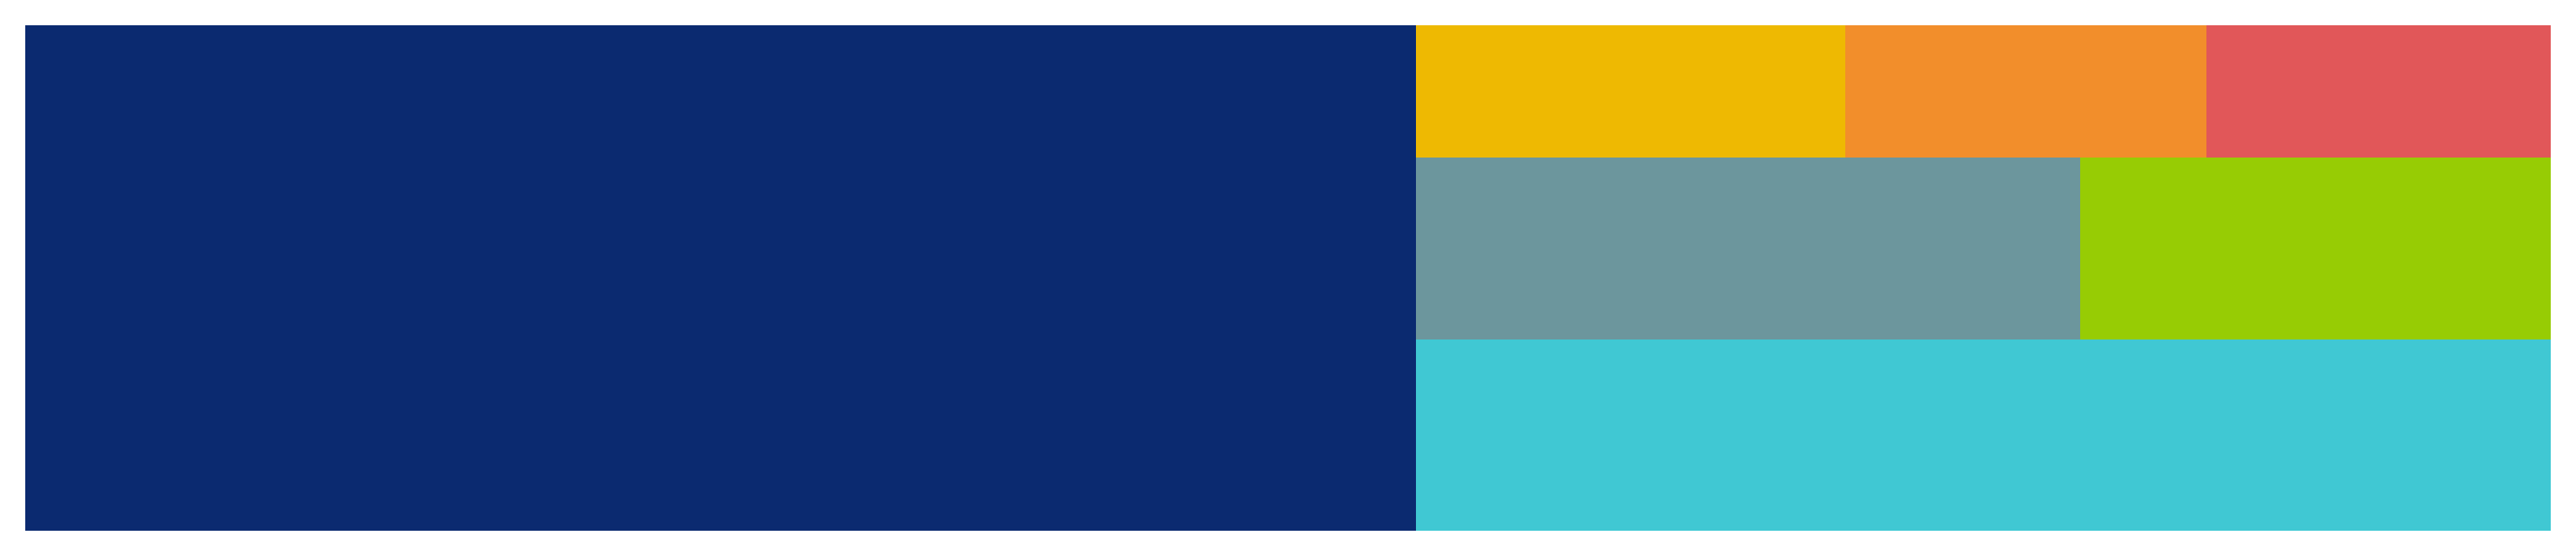

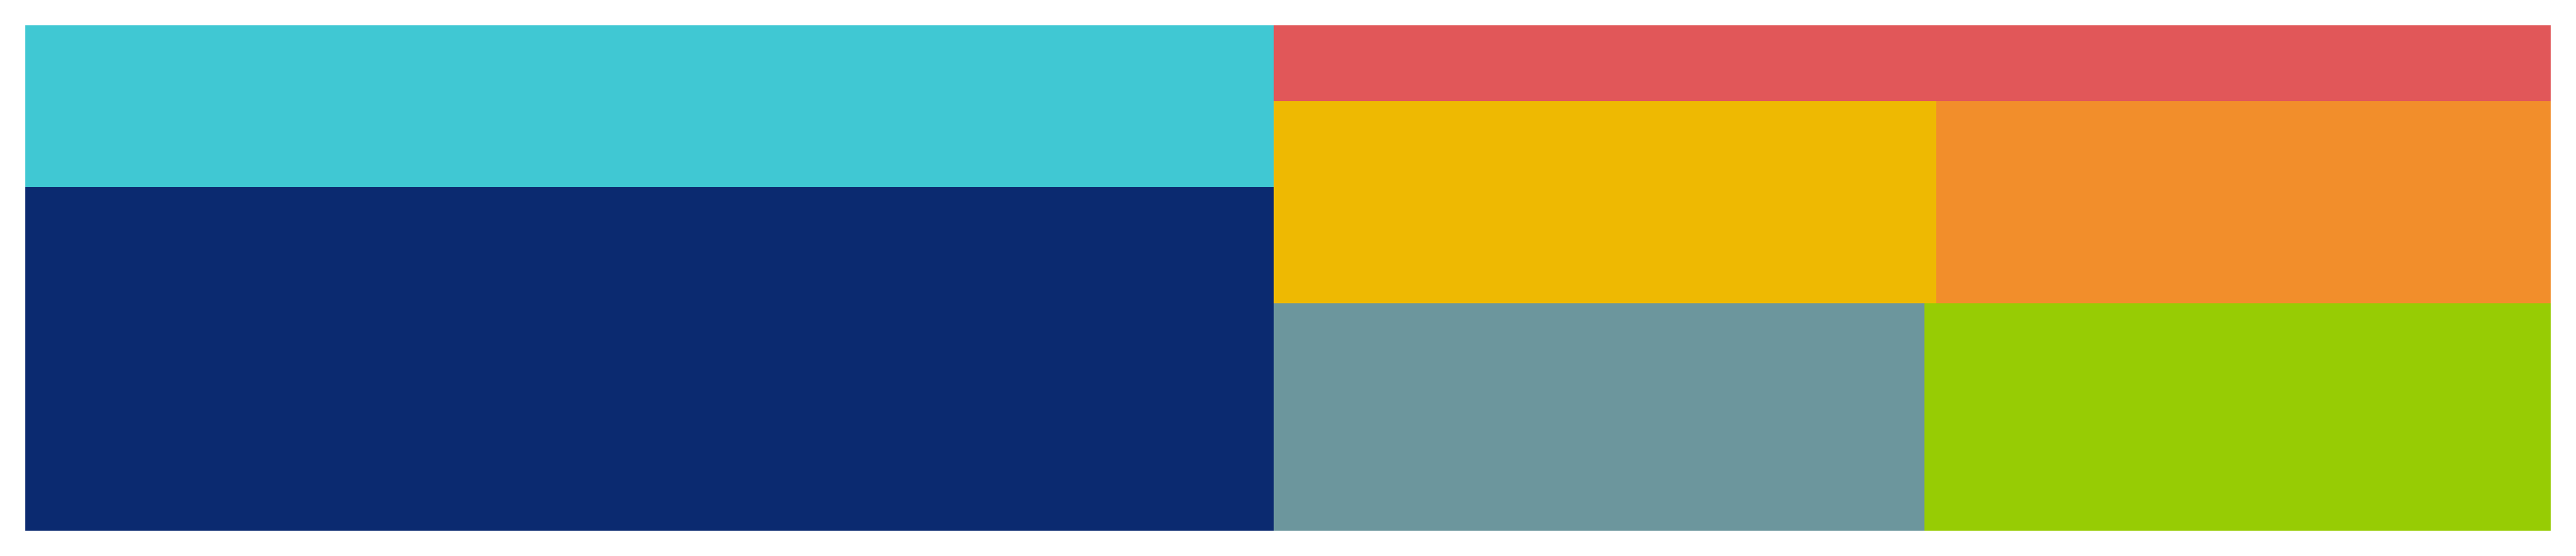

In [221]:
import pandas as pd
import matplotlib.pyplot as plt
import squarify  # For treemap visualization

# Load data using your function
data_non = load_data("rq26-product-combos-nonreturnable.csv")
data_with = load_data("rq26-product-combos-with-returnable.csv")


def treemap_combos(data):
	# Select top 10 product combinations
	top_combinations = data.nlargest(7, 'combination_count')

	# Prepare the data for the treemap
	sizes = top_combinations['combination_count']

	# Use custom colors for the treemap
	colors = [
		get_chart_color(i) for i in range(len(sizes))
	]

	# Create the treemap
	plt.figure(figsize=(10, 2))
	squarify.plot(sizes=sizes, color=colors, bar_kwargs=dict(linewidth=0))

	# Remove labels
	plt.axis('off')
	plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
	return plt


# Show the treemap
plt1 = treemap_combos(data_non)
plt1.savefig("./thesis/results/rq26-product-combos-nonreturnable.png", dpi=300, bbox_inches='tight', pad_inches=0)
plt2 = treemap_combos(data_with)
plt2.savefig("./thesis/results/rq26-product-combos-with-returnable.png", dpi=300, bbox_inches='tight', pad_inches=0)

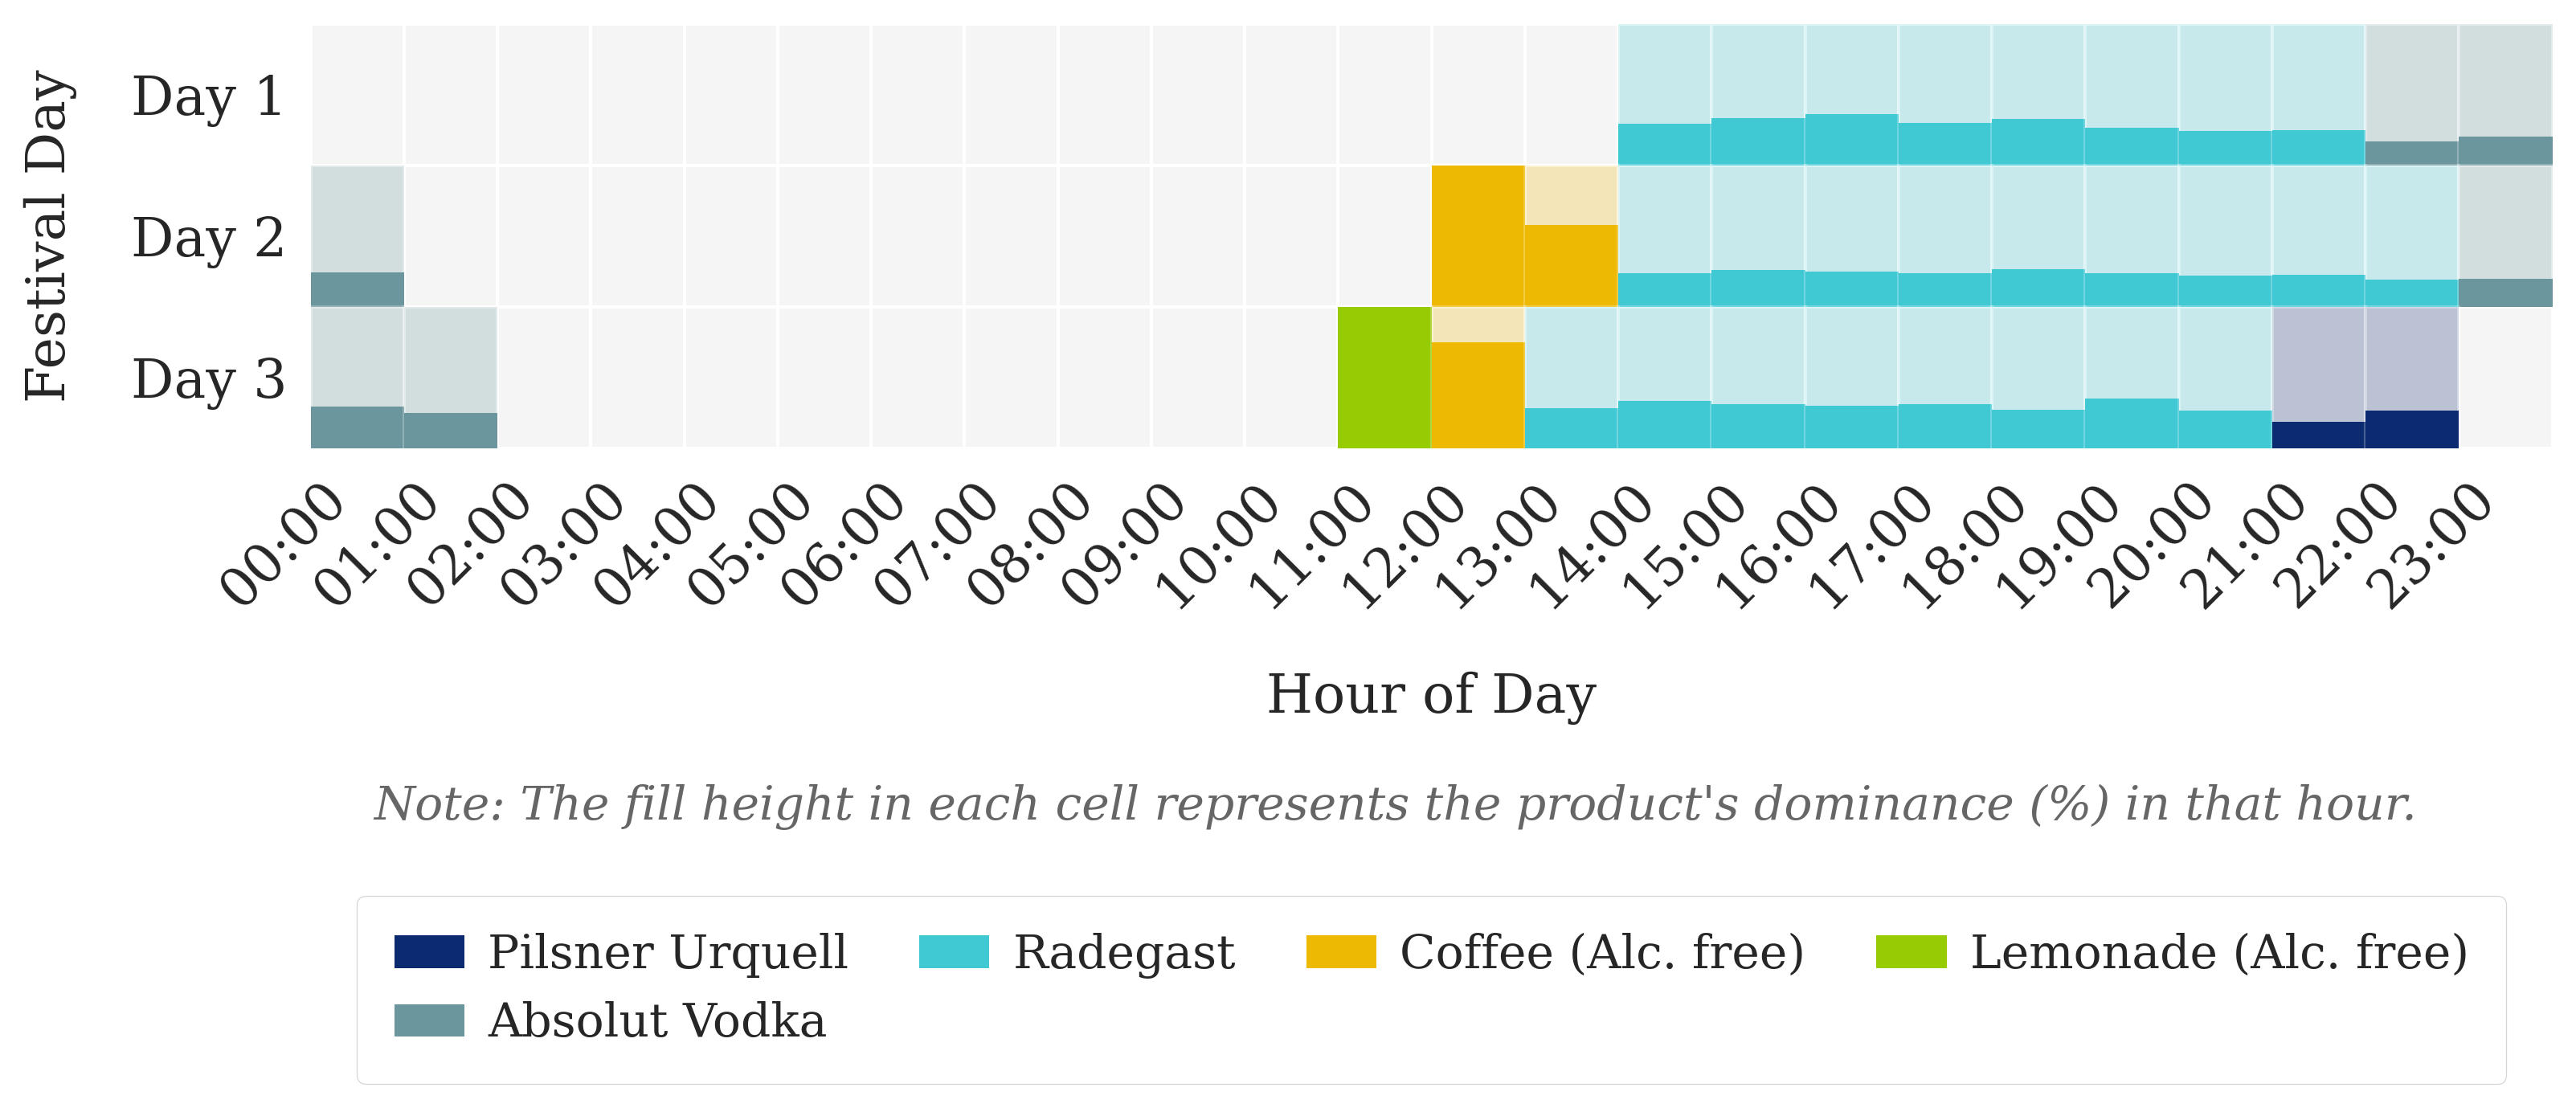

In [222]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.gridspec import GridSpec

# Load and prepare data
df = load_data("rq25-beverage-prefs.csv")
df['datetime'] = pd.to_datetime(df['hour'])
df['day'] = df['datetime'].apply(lambda x: format_event_datetime(x, include_time=False))
df['hour_num'] = df['datetime'].dt.hour

# Color scheme
colors = {
	# 'Radegast': '#97AA84',
	# 'Pilsner Urquell': '#355935',
	# 'Absolut Vodka': '#78C6F5',
	# 'Lemonade': '#E3E3AA',
	# 'Coffee': '#474647',
	'Pilsner Urquell': get_chart_color(0),
	'Radegast': get_chart_color(1),
	'Absolut Vodka': get_chart_color(2),
	'Lemonade': get_chart_color(3),
	'Coffee': get_chart_color(4),
}

# Create figure with specific layout
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 16

# Create figure and gridspec
fig = plt.figure(figsize=(12, 6), facecolor='white')
gs = GridSpec(2, 1, height_ratios=[3, 1], figure=fig)

# Create main plot
ax = fig.add_subplot(gs[0])
ax.set_facecolor('#f5f5f5')

# Create heatmap
days = ['Day 1', 'Day 2', 'Day 3']
hours = range(24)

# First add background for all cells
for i in range(3):
	for j in range(24):
		ax.add_patch(plt.Rectangle((j, 2 - i), 1, 1, facecolor='#f5f5f5', edgecolor='white', linewidth=1))

# Then add colored patches for data with two-layer approach
for i, day in enumerate(days):
	for j, hour in enumerate(hours):
		mask = (df['day'] == day) & (df['hour_num'] == hour)
		if mask.any():
			data = df[mask].iloc[0]
			base_color = colors[data['category']]

			# Convert color to RGB for opacity control
			rgb = plt.cm.colors.to_rgb(base_color)

			# First layer: Full box with low opacity
			ax.add_patch(
				plt.Rectangle(
					(j, 2 - i), 1, 1,
					facecolor=base_color,
					edgecolor='white',
					linewidth=1,
					alpha=0.25  # Low opacity for background
				)
			)

			# Second layer: Partial box showing dominance
			height = data['hour_percentage'] / 100  # Convert percentage to decimal
			ax.add_patch(
				plt.Rectangle(
					(j, 2 - i),  # Same x, starting from bottom
					1,  # Full width
					height,  # Height based on percentage
					facecolor=base_color,
					edgecolor=None,  # No edge to blend better
					alpha=1.0  # Full opacity for dominance indicator
				)
			)

# Customize the plot
ax.set_xlim(0, 24)
ax.set_ylim(0, 3)

# Set ticks and labels
ax.set_xticks(np.arange(24) + 0.5)
ax.set_xticklabels(
	[f'{h:02d}:00' for h in hours],
	rotation=45,
	ha='right',
	fontsize=16
)
ax.set_yticks(np.arange(3) + 0.5)
ax.set_yticklabels(days[::-1], fontsize=16)

# Remove spines
for spine in ax.spines.values():
	spine.set_visible(False)

# Set labels
ax.set_xlabel('Hour of Day', labelpad=16, fontsize=16)
ax.set_ylabel('Festival Day', labelpad=16, fontsize=16)

# Create legend elements
alcoholic_products = [p for p in df[df['is_alcoholic']]['category'].unique()]
non_alcoholic_products = [p for p in df[~df['is_alcoholic']]['category'].unique()]

# Create simple legend elements
legend_elements = [
	plt.Rectangle((0, 0), 1, 1, facecolor=colors[product])
	for product in ['Pilsner Urquell', 'Absolut Vodka', 'Radegast', 'Coffee', 'Lemonade']
]

legend_labels = ['Pilsner Urquell', 'Absolut Vodka', 'Radegast', 'Coffee (Alc. free)', 'Lemonade (Alc. free)']

# Create legend with wide span
legend = ax.legend(
	legend_elements,
	legend_labels,
	bbox_to_anchor=(0.5, -1),  # Centered, closer to plot
	loc='upper center',
	ncol=4,  # All items in one row
	fontsize=14,
	frameon=True,
	edgecolor='#cccccc',
	borderpad=0.8,
	columnspacing=1.5,  # Space between columns
	handletextpad=0.5,  # Space between square and text
	handlelength=1.5,  # Square size
)

# After the legend creation, add an annotation
fig.text(
	0.5, 0.33,
	'Note: The fill height in each cell represents the product\'s dominance (%) in that hour.',
	ha='center',
	fontsize=14,
	color='#666666',
	style='italic'
)

# Adjust layout
plt.subplots_adjust(bottom=0.45)

plt.savefig("./thesis/results/rq25-beverage-preferences.png", dpi=300, bbox_inches='tight', pad_inches=0.1)


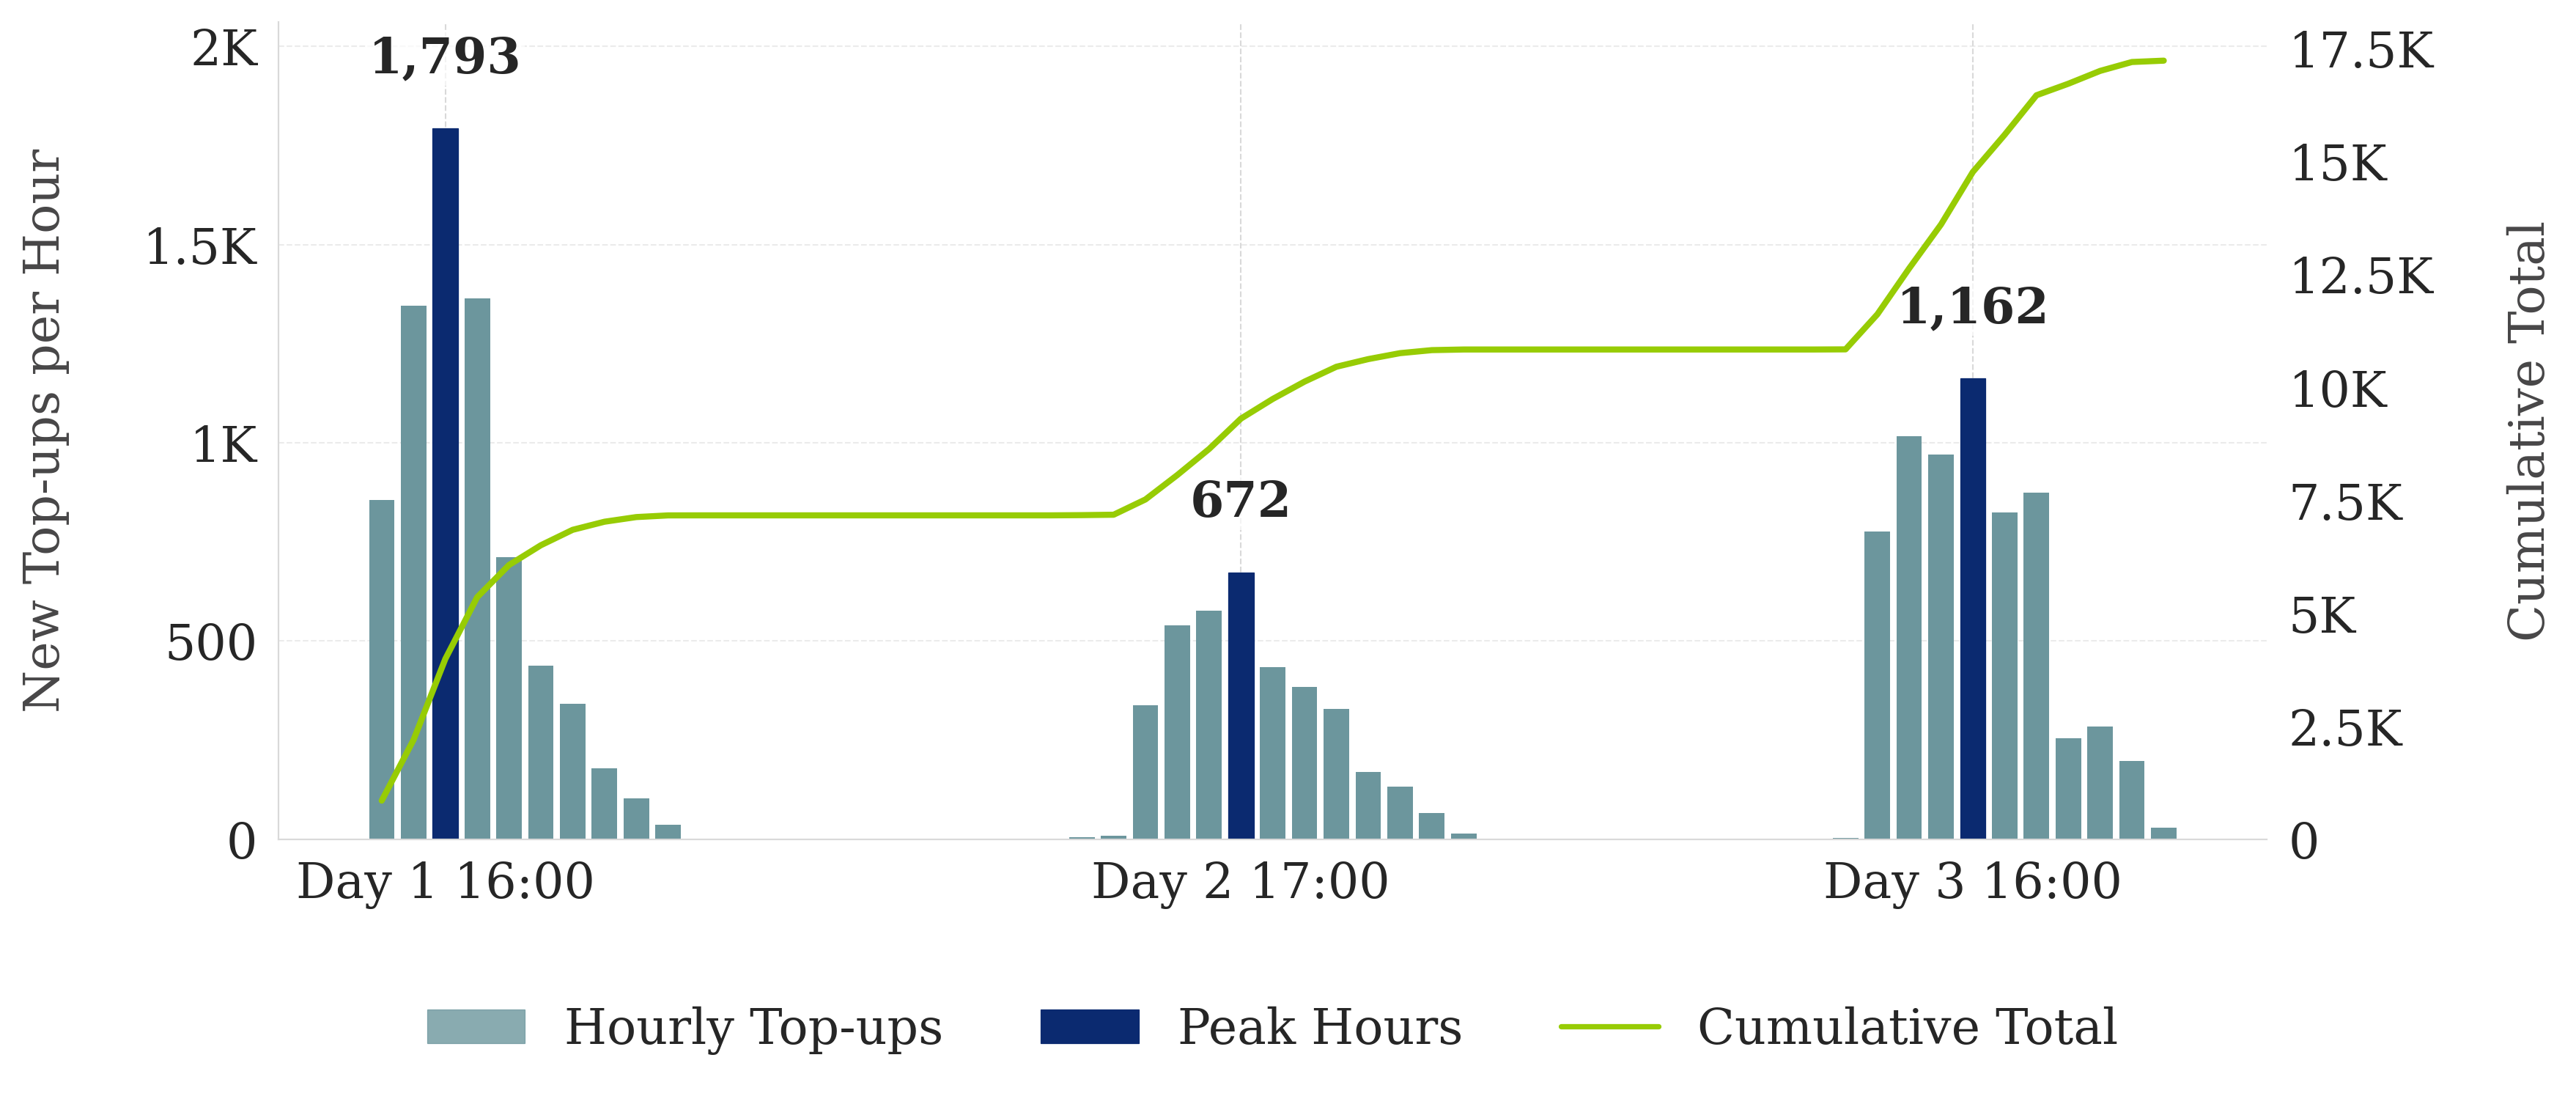

In [223]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
from matplotlib.ticker import AutoMinorLocator

# Set up the figure with specific size
df = load_data("rq23-topup-patterns.csv")
df['hour'] = pd.to_datetime(df['hour'])

plt.figure(figsize=(12, 6))
ax1 = plt.gca()
ax2 = ax1.twinx()

# Set y-axis limits with padding to prevent overflow
max_topups = df['topup_count'].max()
y_max = max_topups * 1.15  # Add 15% padding
ax1.set_ylim(0, y_max)
ax2.set_ylim(0, df['total_topup_count'].max() * 1.05)  # 5% padding for cumulative

# Create bar chart for hourly top-ups
x = mdates.date2num(df['hour'])
width = (x[1] - x[0]) * 0.8

bars = ax1.bar(
	x,
	df['topup_count'],
	width=width,
	color=get_chart_color(2),
)

# Plot cumulative line
line = ax2.plot(
	x,
	df['total_topup_count'],
	color=get_chart_color(3),
	linewidth=2,
	label='Cumulative Total'
)

# Improve grid styling
ax1.set_axisbelow(True)
ax2.set_axisbelow(True)
ax1.grid(axis='y', linestyle='--', alpha=0.5)
ax2.grid(axis='y', linestyle='--', alpha=0)

peak_positions = []
peak_times = []

# Find daily peaks and highlight them
for day in pd.date_range('2024-07-04', '2024-07-06'):
	day_data = df[df['hour'].dt.strftime('%Y-%m-%d') == day.strftime('%Y-%m-%d')]
	if len(day_data) > 0:
		peak_hour = day_data.nlargest(1, 'topup_count').iloc[0]
		idx = df.index[df['hour'] == peak_hour['hour']][0]
		bars[idx].set_color(get_chart_color(0))
		bars[idx].set_alpha(1.0)

		peak_positions.append(x[idx])
		peak_times.append(peak_hour['hour'])

		# Improve peak annotations
		ax1.annotate(
			f'{int(peak_hour["topup_count"]):,}',
			xy=(x[idx], peak_hour['topup_count']),
			xytext=(0, 15),  # Increased vertical offset
			textcoords='offset points',
			ha='center',
			va='bottom',
			fontweight='bold',
			fontsize=16,
			bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=1)
		)

# Format axes with improved spacing
ax1.set_ylabel('New Top-ups per Hour', fontsize=16, labelpad=24, color=get_chart_color('text'))
ax2.set_ylabel('Cumulative Total', fontsize=16, labelpad=24, color=get_chart_color('text'))
ax1.tick_params(axis='both', labelsize=16)
ax2.tick_params(axis='y', labelsize=16)

# Format x-axis
ax1.set_xticks(peak_positions)
ax1.xaxis.set_major_formatter(
	plt.FuncFormatter(
		lambda x, p: format_event_datetime(mdates.num2date(x))
	)
)
plt.xticks(rotation=45, ha='right')

# Format y-axis numbers
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format_number_short(x)))
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format_number_short(x)))

# Improved legend - moved below the chart
legend_elements = [
	plt.Rectangle((0, 0), 1, 1, color=get_chart_color(2), alpha=0.8, label='Hourly Top-ups'),
	plt.Rectangle((0, 0), 1, 1, color=get_chart_color(0), label='Peak Hours'),
	plt.Line2D([0], [0], color=get_chart_color(3), label='Cumulative Total')
]
ax1.legend(
	handles=legend_elements,
	loc='upper center',
	fontsize=16,
	bbox_to_anchor=(0.5, -0.15),  # Moved below by adjusting y coordinate
	ncol=3
)

# Adjust layout with more bottom padding to accommodate legend
plt.tight_layout(rect=[0, 0.1, 1, 1])  # Added padding at bottom [left, bottom, right, top]

plt.savefig("./thesis/results/rq23-topup-patterns.png", dpi=300, bbox_inches='tight', pad_inches=0.1)

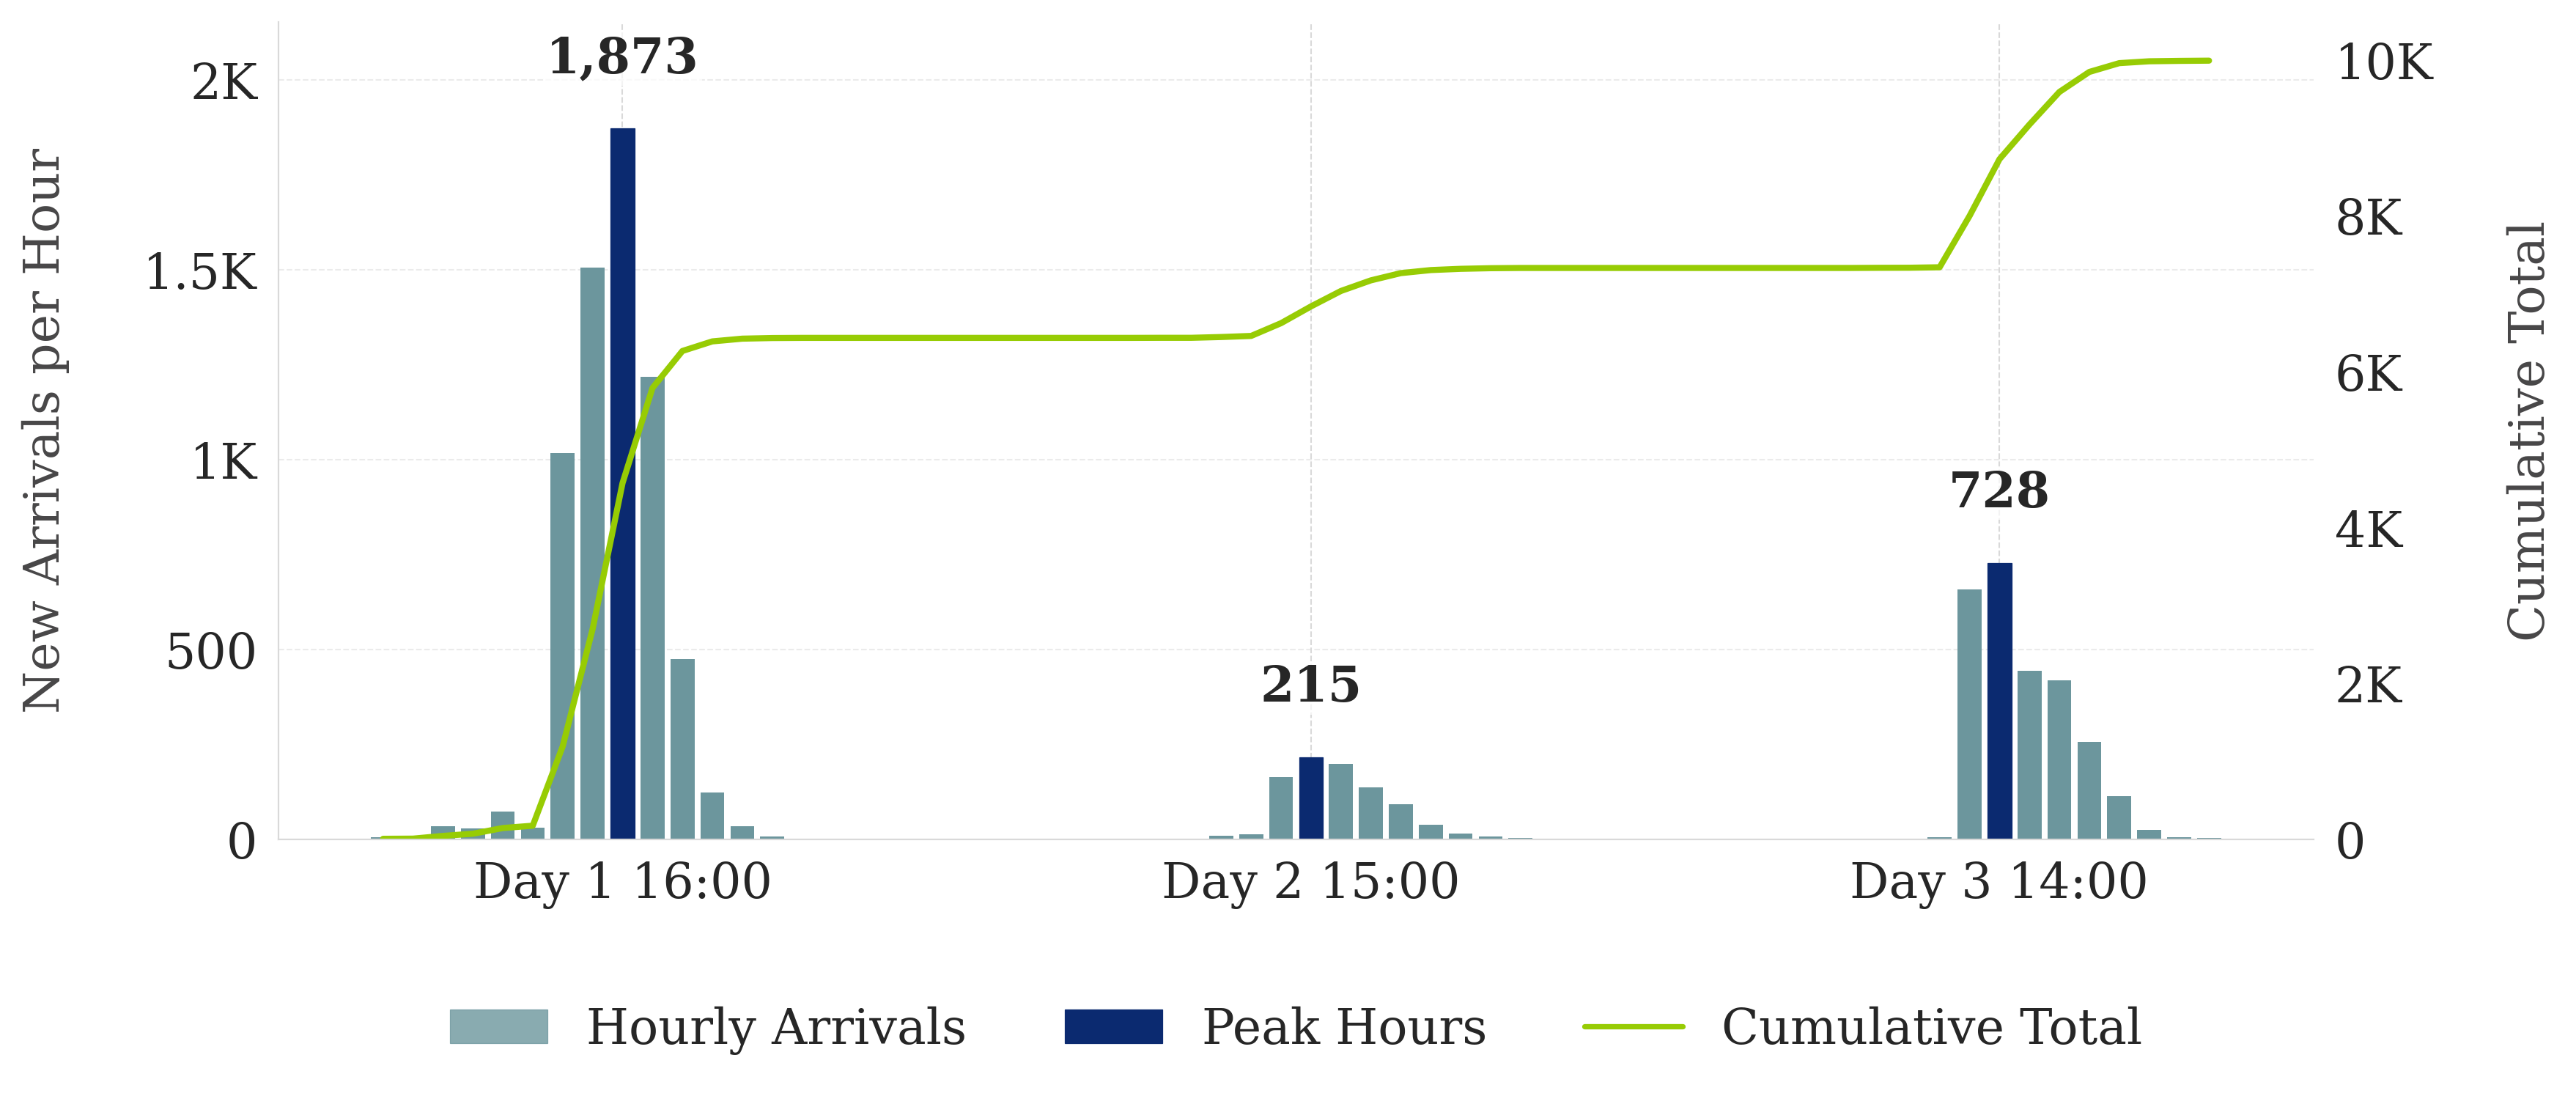

In [224]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
from matplotlib.ticker import AutoMinorLocator

# Set up the figure with specific size
df = load_data("rq21-arrival-patterns.csv")
df['hour'] = pd.to_datetime(df['hour'])

plt.figure(figsize=(12, 6))
ax1 = plt.gca()
ax2 = ax1.twinx()

# Set y-axis limits with padding to prevent overflow
max_registrations = df['register_count'].max()
y_max = max_registrations * 1.15  # Add 15% padding
ax1.set_ylim(0, y_max)
ax2.set_ylim(0, df['total_register_count'].max() * 1.05)  # 5% padding for cumulative

# Create bar chart for hourly top-ups
x = mdates.date2num(df['hour'])
width = (x[1] - x[0]) * 0.8

bars = ax1.bar(
	x,
	df['register_count'],
	width=width,
	color=get_chart_color(2),
)

# Plot cumulative line
line = ax2.plot(
	x,
	df['total_register_count'],
	color=get_chart_color(3),
	linewidth=2,
	label='Cumulative Total'
)

# Improve grid styling
ax1.set_axisbelow(True)
ax2.set_axisbelow(True)
ax1.grid(axis='y', linestyle='--', alpha=0.5)
ax2.grid(axis='y', linestyle='--', alpha=0)

peak_positions = []
peak_times = []

# Find daily peaks and highlight them
for day in pd.date_range('2024-07-04', '2024-07-06'):
	day_data = df[df['hour'].dt.strftime('%Y-%m-%d') == day.strftime('%Y-%m-%d')]
	if len(day_data) > 0:
		peak_hour = day_data.nlargest(1, 'register_count').iloc[0]
		idx = df.index[df['hour'] == peak_hour['hour']][0]
		bars[idx].set_color(get_chart_color(0))
		bars[idx].set_alpha(1.0)

		peak_positions.append(x[idx])
		peak_times.append(peak_hour['hour'])

		# Improve peak annotations
		ax1.annotate(
			f'{int(peak_hour["register_count"]):,}',
			xy=(x[idx], peak_hour['register_count']),
			xytext=(0, 15),  # Increased vertical offset
			textcoords='offset points',
			ha='center',
			va='bottom',
			fontweight='bold',
			fontsize=16,
			bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=1)
		)

# Format axes with improved spacing
ax1.set_ylabel('New Arrivals per Hour', fontsize=16, labelpad=24, color=get_chart_color('text'))
ax2.set_ylabel('Cumulative Total', fontsize=16, labelpad=24, color=get_chart_color('text'))
ax1.tick_params(axis='both', labelsize=16)
ax2.tick_params(axis='y', labelsize=16)

# Format x-axis
ax1.set_xticks(peak_positions)
ax1.xaxis.set_major_formatter(
	plt.FuncFormatter(
		lambda x, p: format_event_datetime(mdates.num2date(x))
	)
)
plt.xticks(rotation=45, ha='right')

# Format y-axis numbers
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format_number_short(x)))
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format_number_short(x)))

# Improved legend - moved below the chart
legend_elements = [
	plt.Rectangle((0, 0), 1, 1, color=get_chart_color(2), alpha=0.8, label='Hourly Arrivals'),
	plt.Rectangle((0, 0), 1, 1, color=get_chart_color(0), label='Peak Hours'),
	plt.Line2D([0], [0], color=get_chart_color(3), label='Cumulative Total')
]
ax1.legend(
	handles=legend_elements,
	loc='upper center',
	fontsize=16,
	bbox_to_anchor=(0.5, -0.15),  # Moved below by adjusting y coordinate
	ncol=3
)

# Adjust layout with more bottom padding to accommodate legend
plt.tight_layout(rect=[0, 0.1, 1, 1])  # Added padding at bottom [left, bottom, right, top]

plt.savefig("./thesis/results/rq21-arrival-patterns.png", dpi=300, bbox_inches='tight', pad_inches=0.1)

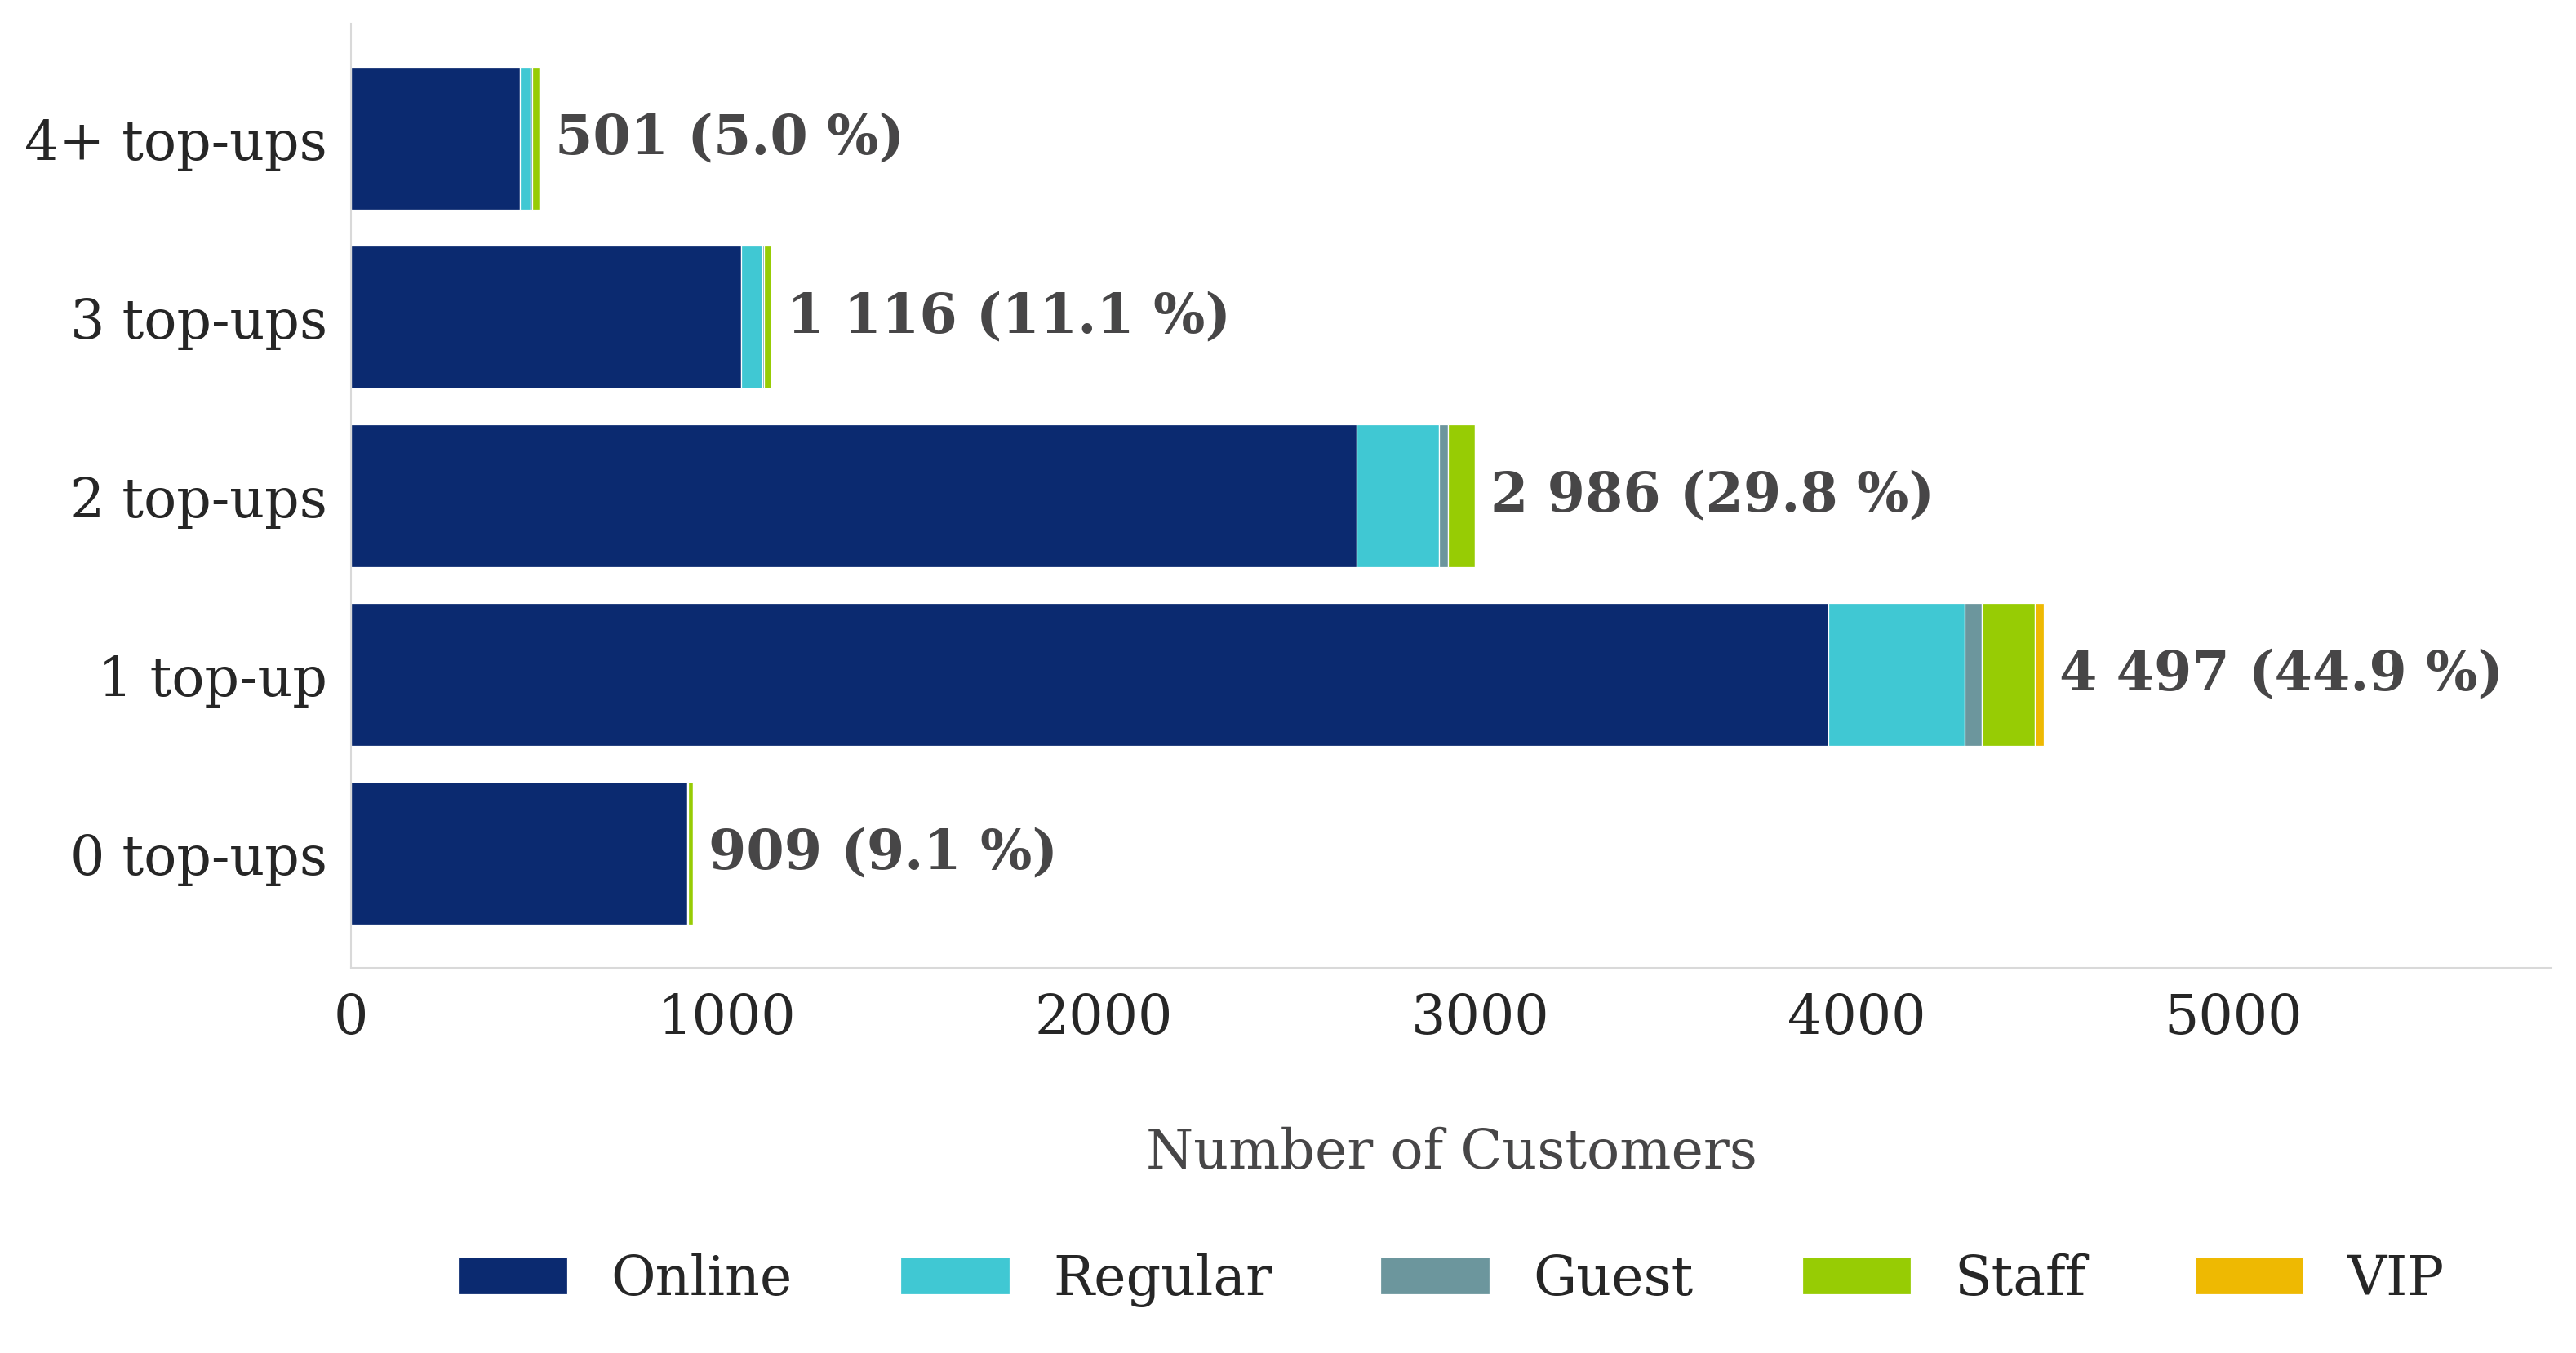

In [225]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read and prepare data
df = load_data("rq24-topup-frequency.csv")

# Create categories for number of topups
categories = ['0 top-ups', '1 top-up', '2 top-ups', '3 top-ups', '4+ top-ups']
chip_types = ['Pass', 'POS', 'Guest', 'Staff', 'POS VIP']

# Process data
data_matrix = np.zeros((len(categories), len(chip_types)))

for i, cat_idx in enumerate(range(5)):  # 0 through 4+
	for j, chip in enumerate(chip_types):
		chip_data = df[df['chip_type'] == chip]
		if cat_idx == 4:  # 4+ category
			count = chip_data[chip_data['onsite_topup_count'] >= 4]['count'].sum()
		else:
			count = chip_data[chip_data['onsite_topup_count'] == cat_idx]['count'].sum()
		data_matrix[i, j] = count

# Create horizontal stacked bar chart
fig, ax = plt.subplots(figsize=(12, 6))

left = np.zeros(len(categories))
bars = []
colors = [get_chart_color(i) for i in range(len(chip_types))]

# Calculate row sums for totals
row_sums = data_matrix.sum(axis=1)

for i, chip in enumerate(chip_types):
	labels = {
		'Pass': 'Online',
		'POS': 'Regular',
		'Guest': 'Guest',
		'Staff': 'Staff',
		'POS VIP': 'VIP',
	}
	bar = ax.barh(
		categories, data_matrix[:, i], left=left,
		color=colors[i],
		label=labels[chip],
		edgecolor='white',
	)
	left += data_matrix[:, i]
	bars.append(bar)

# Add total values to the left of bars
for idx, total in enumerate(row_sums):
	ax.text(
		total + 42,
		idx,
		f"{format_number(total, 0)} ({format_percent(total / row_sums.sum() * 100)})",
		ha='left',
		va='center',
		color=get_chart_color('text'),
		fontsize=16,
		fontweight='bold'
	)

ax.set_xlabel('Number of Customers', fontsize=16, labelpad=24, color=get_chart_color('text'))
ax.tick_params(axis='both', labelsize=16)

# Add legend below the chart
ax.legend(
	loc='upper center',
	bbox_to_anchor=(0.5, -0.25),
	ncol=len(chip_types),
	fontsize=16
)

# Format axis
ax.grid(False)
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

x_max = data_matrix.sum(axis=1).max() * 1.3
ax.set_xlim(0, x_max)

# Adjust layout and margins to accommodate the totals
plt.tight_layout(rect=[0.1, 0, 1, 1])  # Increased left margin

plt.savefig("./thesis/results/rq24-topup-frequency.png", dpi=300, bbox_inches='tight', pad_inches=0.1)

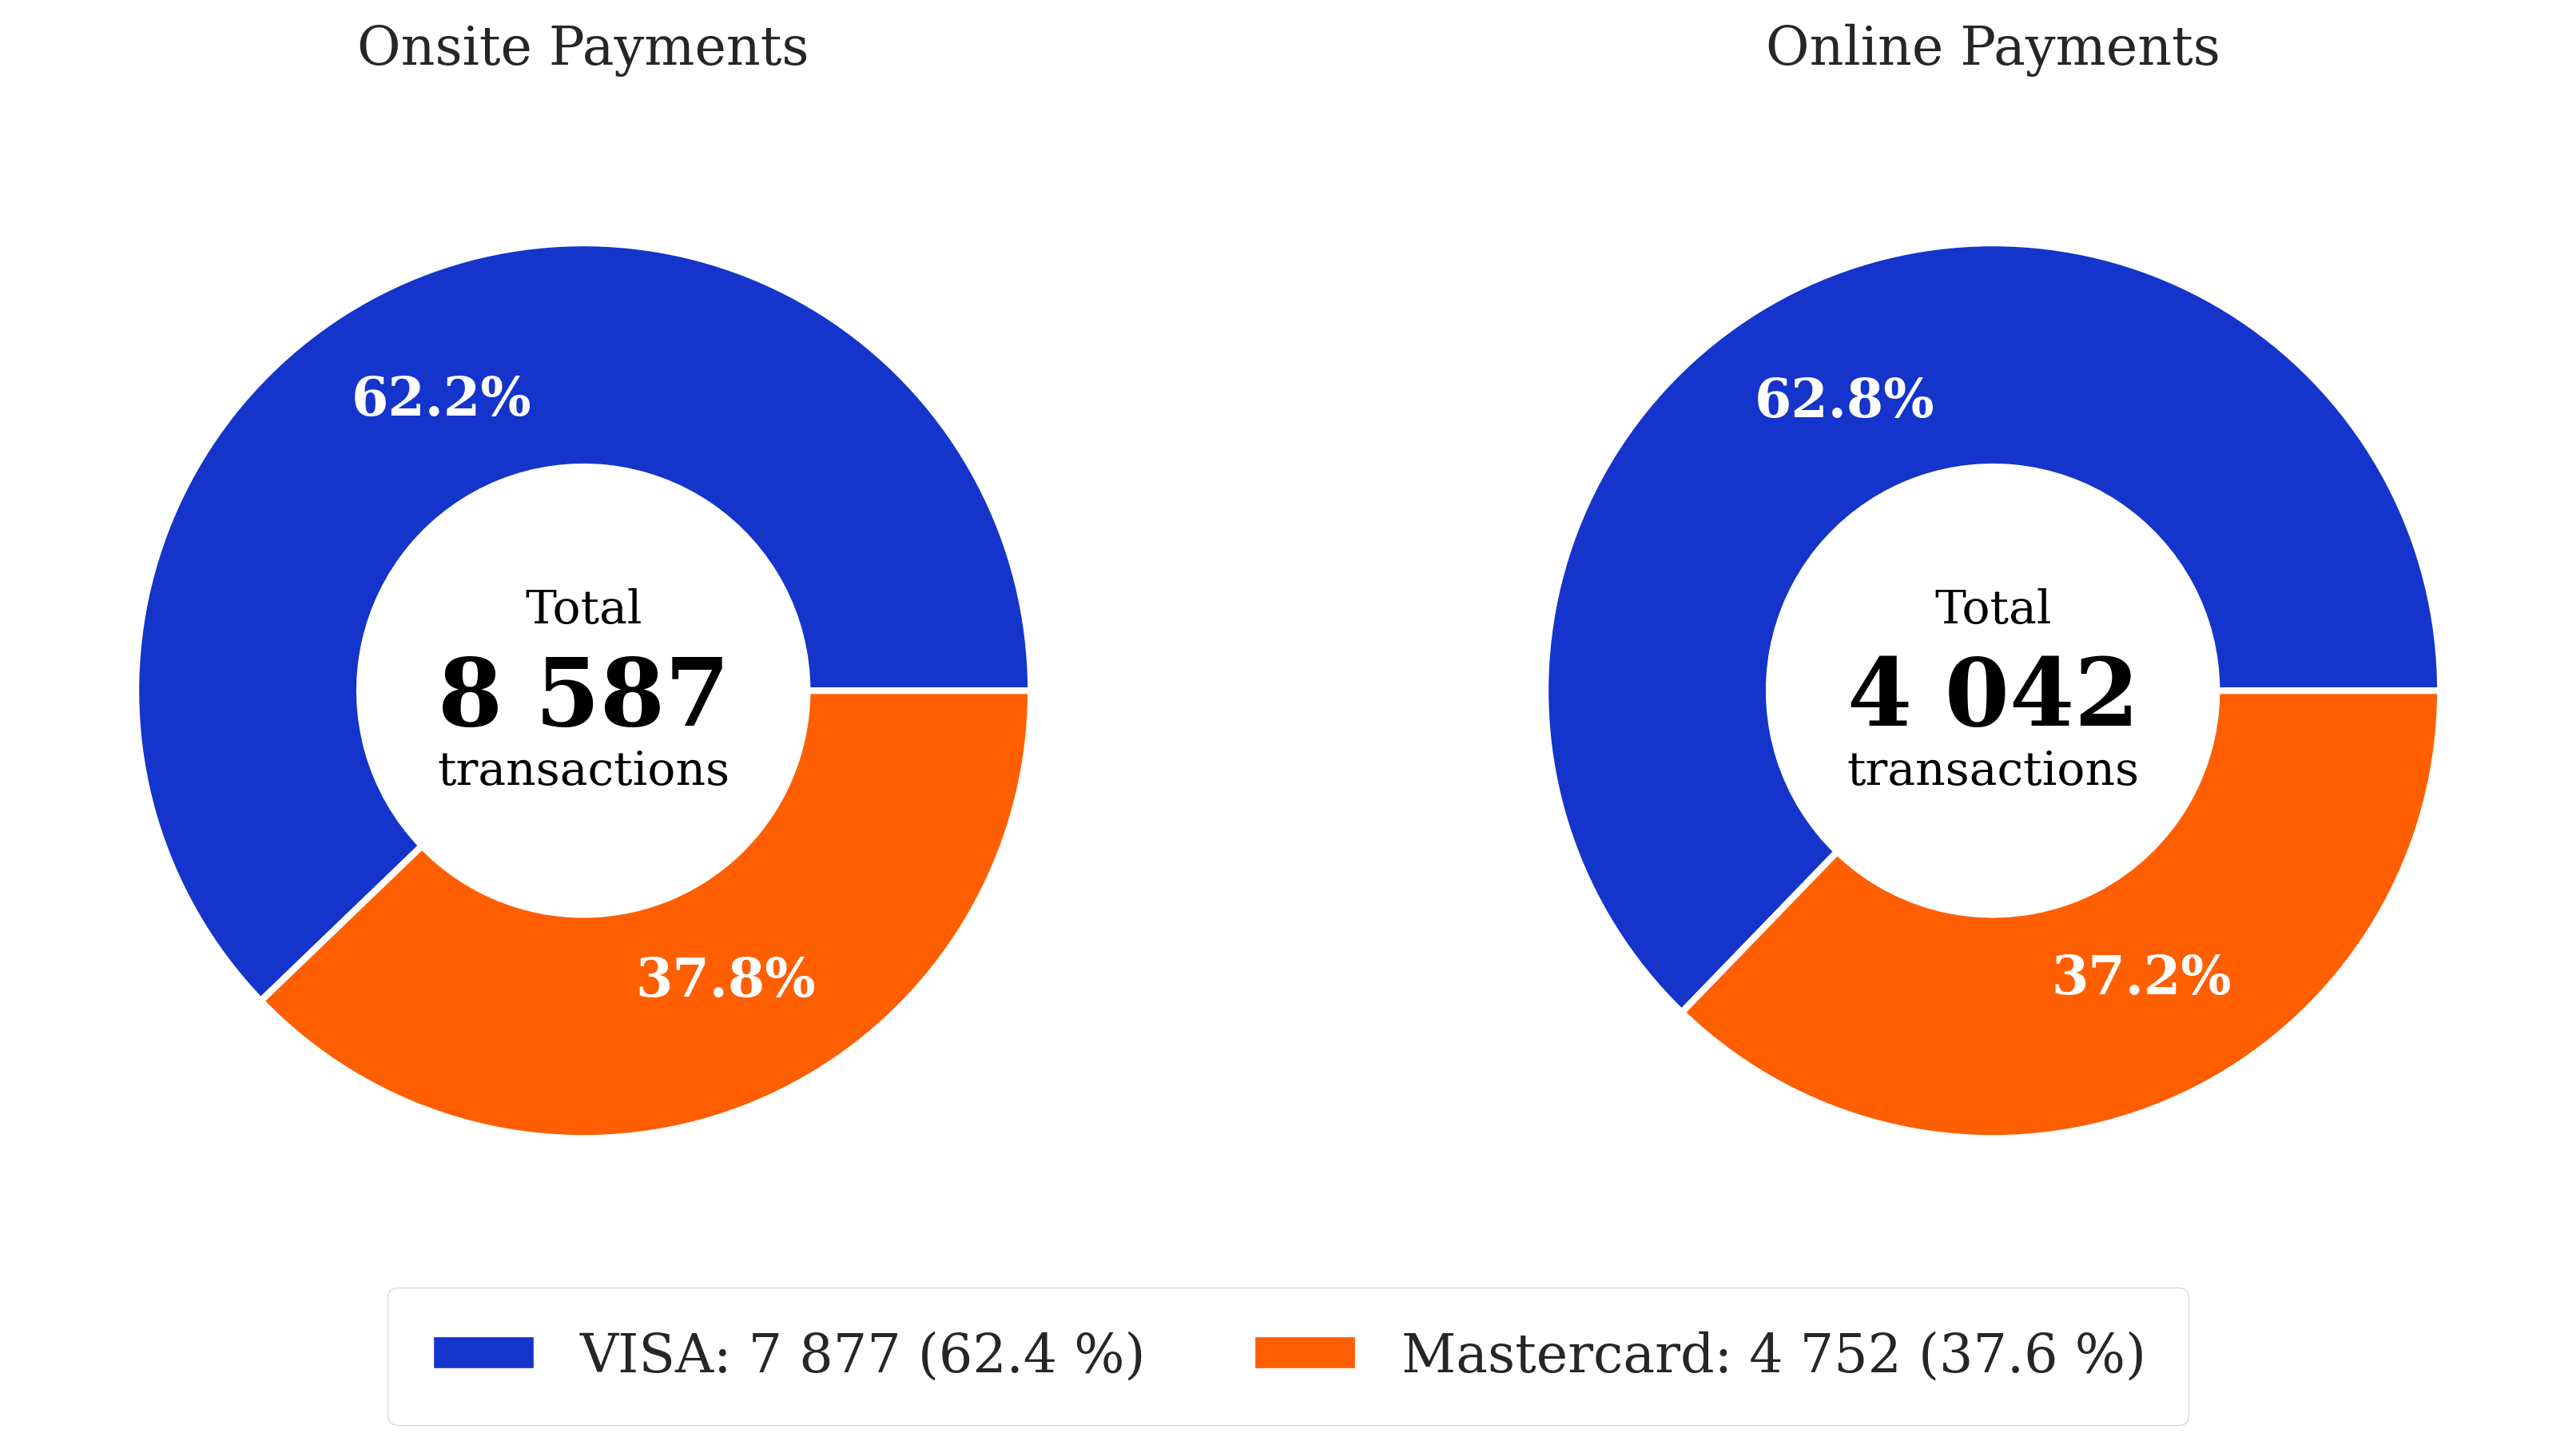

In [226]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Data preparation
data = {
	'count': [2537, 1505, 5340, 3247],
	'payment_type': ['online', 'online', 'onsite', 'onsite'],
	'card': ['VISA', 'MC', 'VISA', 'MC']
}
df = pd.DataFrame(data)

# Group data by payment type and card
grouped = df.groupby(['payment_type', 'card'])['count'].sum().unstack()

# Extract data for each payment type
onsite = grouped.loc['onsite'][::-1]
online = grouped.loc['online'][::-1]

# Shared settings
colors = ['#1434CB', '#FF5F00']  # VISA blue, MC orange
labels = ['VISA', 'Mastercard']


def plot_donut(ax, values, title, cls, labels):
	# Calculate total and percentages
	total = sum(values)
	percentages = [v / total * 100 for v in values]

	# Create donut chart
	wedges, texts = ax.pie(
		values,
		colors=cls,
		labels=None,
		autopct=None,
		wedgeprops={
			'width': 0.5,
			'edgecolor': 'white',
			'linewidth': 2
		}
	)

	# Add percentages to the wedges
	for i, p in enumerate(percentages):
		angle = (wedges[i].theta2 + wedges[i].theta1) / 2
		x = 0.85 * wedges[i].r * np.cos(np.radians(angle))
		y = 0.7 * wedges[i].r * np.sin(np.radians(angle))
		ax.text(
			x, y, f'{p:.1f}%', ha='center', va='center',
			fontsize=16, color='white', fontweight='bold'
		)

	# Add white circle in center
	centre_circle = plt.Circle((0, 0), 0.5, color='white', linewidth=0)
	ax.add_artist(centre_circle)

	# Add center text
	ax.text(0, 0.18, 'Total', ha='center', va='center', fontsize=14, fontweight='normal', color='black')
	ax.text(0, -0.02, f'{format_number(total, 0)}', ha='center', va='center', fontsize=28, fontweight='bold', color='black')
	ax.text(0, -0.18, 'transactions', ha='center', va='center', fontsize=14, fontweight='normal', color='black')
	ax.set_title(title, fontsize=16, pad=20)


# Create figure and axes
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot donuts
plot_donut(axs[0], onsite.values, 'Onsite Payments', colors, labels)
plot_donut(axs[1], online.values, 'Online Payments', colors, labels)

# Add legend
fig.legend(
	labels=[
		f"VISA: {format_number(onsite['VISA'] + online['VISA'], 0)} ({format_percent((onsite['VISA'] + online['VISA']) / df['count'].sum() * 100)})",
		f"Mastercard: {format_number(onsite['MC'] + online['MC'], 0)} ({format_percent((onsite['MC'] + online['MC']) / df['count'].sum() * 100)})"
	],
	loc='lower center',
	bbox_to_anchor=(0.5, -0),
	ncol=2,
	fontsize=16,  # Increased font size for legend,
	frameon=True,
	edgecolor='#cccccc',
	borderpad=0.8,
)

# Set aspect ratio and layout
plt.tight_layout(rect=[0, 0.1, 1, 1])

plt.savefig("./thesis/results/rq20-card-schemes.png", dpi=300, bbox_inches='tight', pad_inches=0.1)


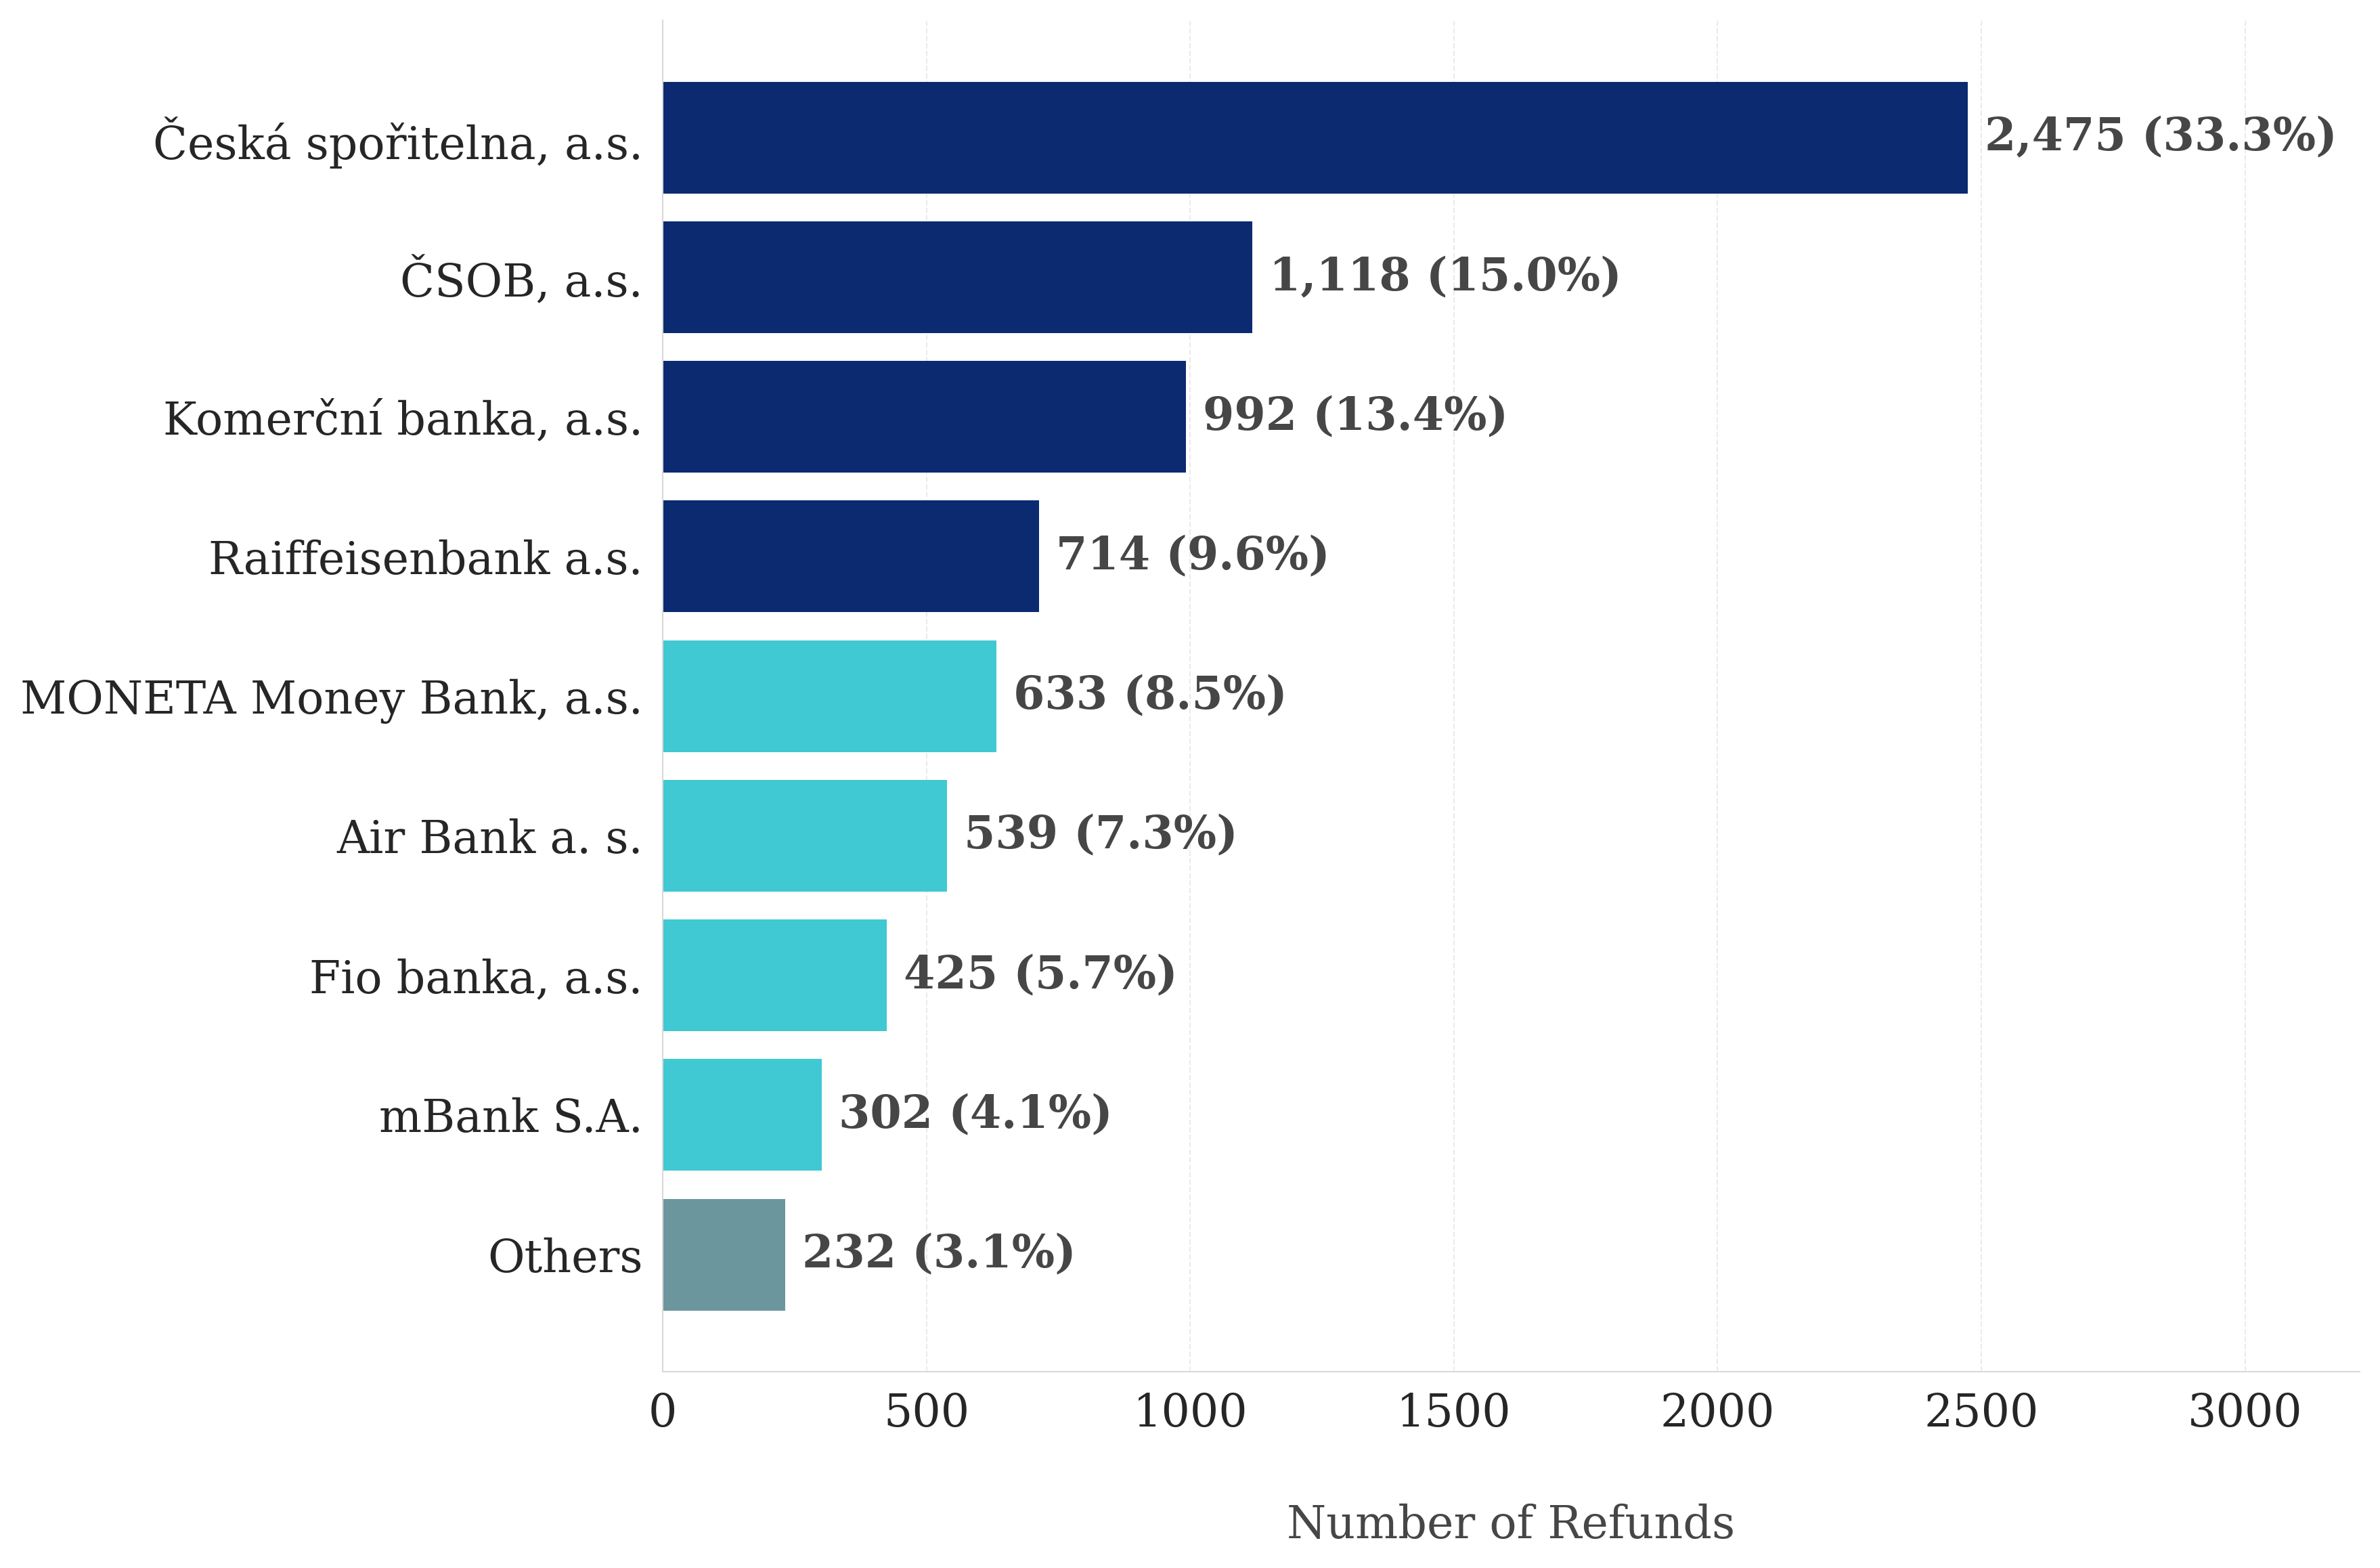

In [227]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read and prepare data
df = load_data("rq19-bank-refunds.csv")
# Omit null values
df = df.dropna(subset=['bank_name'])
df = df.sort_values('count', ascending=True)  # Sort for better visualization

# Group smaller banks together
threshold = 300
main_banks = df[df['count'] >= threshold].copy()
others = df[df['count'] < threshold]
others_sum = pd.DataFrame(
	{
		'bank_name': ['Others'],
		'count': [others['count'].sum()]
	}
)

# Combine main banks and others
df_plot = pd.concat([main_banks, others_sum])
df_plot = df_plot.sort_values('count', ascending=True)

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Create horizontal bars
bars = []
for i, bank in enumerate(df_plot['bank_name']):
	reversed_i = len(df_plot) - i - 1  # Reverse order for better visualization
	bar = ax.barh(
		bank,
		df_plot['count'].iloc[i],
		color=get_chart_color(0 if reversed_i <= 3 else 2 if bank == 'Others' else 1),
	)
	bars.append(bar[0])

# Add value labels on the bars
for bar in bars:
	width = bar.get_width()
	percentage = (width / df['count'].sum()) * 100

	label = f'{int(width):,} ({percentage:.1f}%)'

	ax.text(
		width + 32,  # Slight padding
		bar.get_y() + bar.get_height() / 2,
		label,
		va='center',
		fontsize=16,
		color=get_chart_color('text'),
		fontweight='bold'
	)

# Customize chart
ax.set_xlabel('Number of Refunds', fontsize=16, labelpad=24, color=get_chart_color('text'))
ax.tick_params(axis='both', labelsize=16)

# Format axis
ax.grid(True, axis='x', alpha=0.2)
ax.set_axisbelow(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add padding to x-axis for labels
x_max = df_plot['count'].max()
ax.set_xlim(0, x_max * 1.3)  # Add 25% padding for labels

# hide grid y-axis
ax.grid(axis='y', linestyle='--', alpha=0)
ax.grid(axis='x', linestyle='--', alpha=0.5)

# Adjust layout
plt.tight_layout()

plt.savefig("./thesis/results/rq19-bank-refunds.png", dpi=300, bbox_inches='tight', pad_inches=0.1)

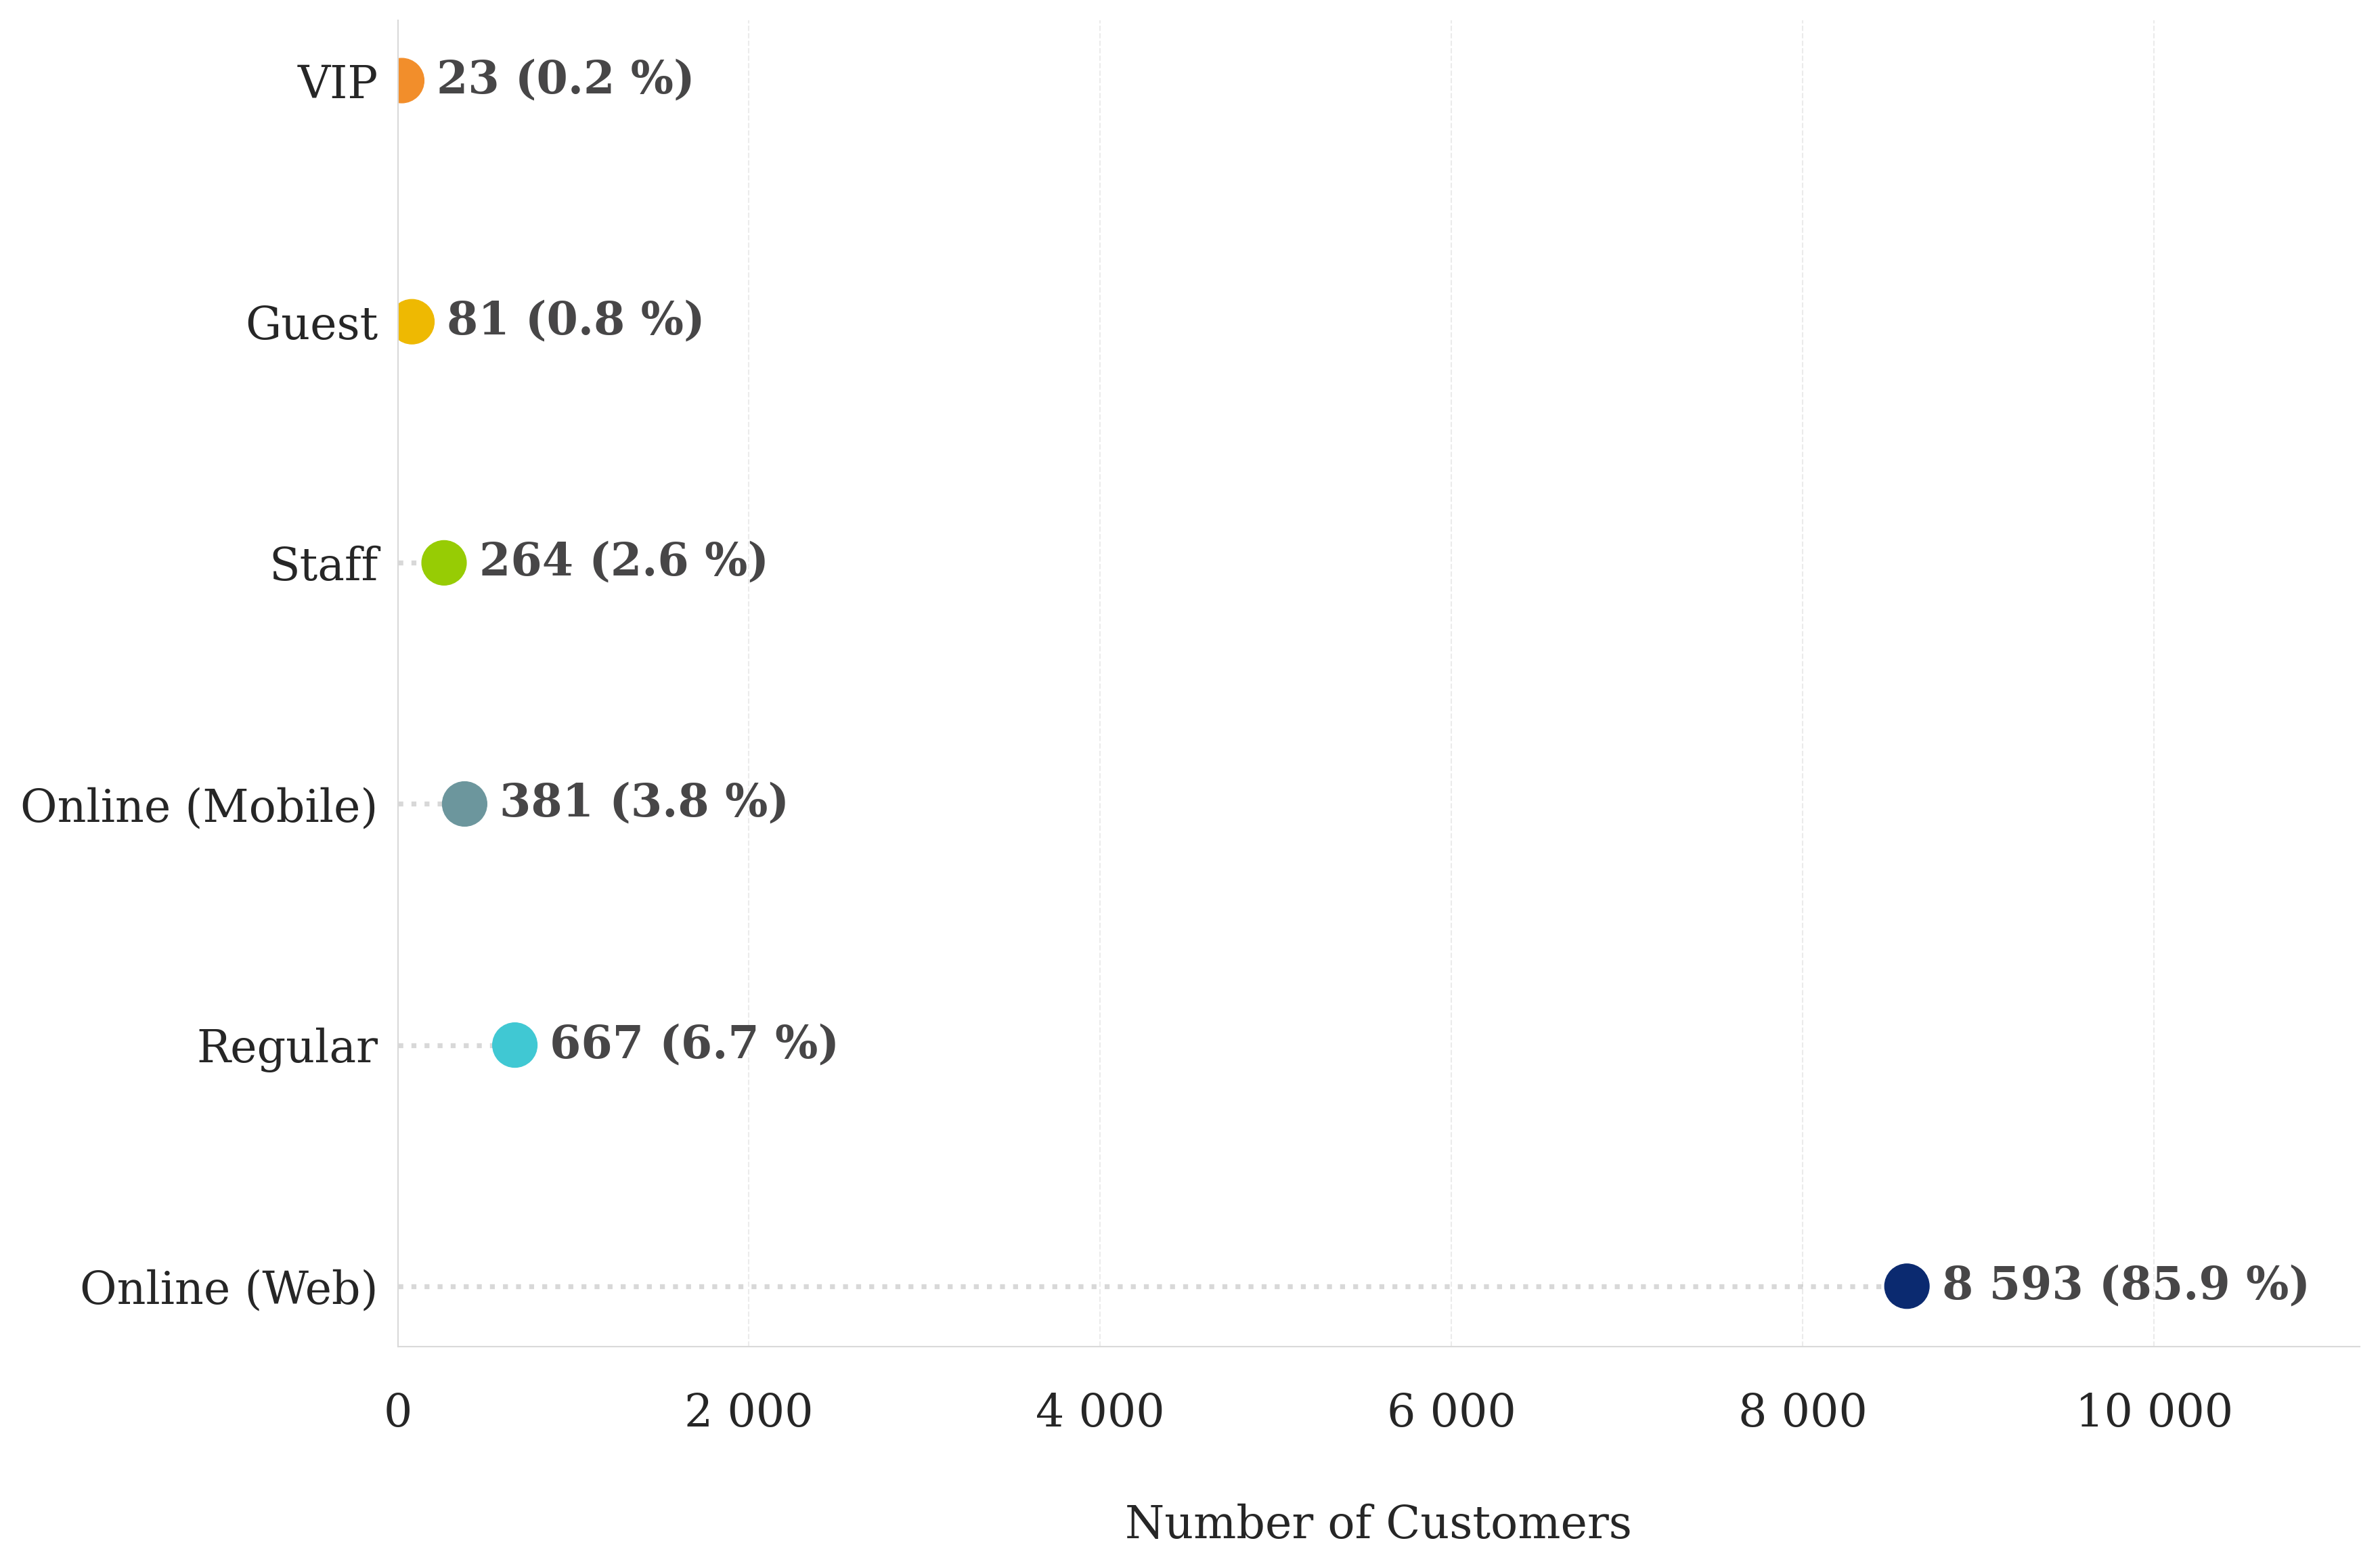

In [228]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read and prepare data
df = load_data("rq28-customer-distribution.csv")

# Calculate total for percentages
total = df['count'].sum()

# Create type mapping for better labels
type_labels = {
	'Pass': 'Online (Web)',
	'iOS': 'Online (Mobile)',
	'Android': 'Android App',
	'POS': 'Regular',
	'POS VIP': 'VIP',
	'Staff': 'Staff',
	'Guest': 'Guest'
}

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Create y-positions
positions = np.arange(len(df))

# Plot dots
dots = ax.scatter(
	df['count'],
	positions,
	s=250,  # Size of dots
	color=[get_chart_color(i) for i in range(len(df))],
	zorder=2  # Ensure dots are above grid lines
)

# Add connecting lines from y-axis to dots
for i, count in enumerate(df['count']):
	ax.plot(
		[0, count],
		[positions[i], positions[i]],
		color='gray',
		linestyle=':',
		alpha=0.3,
		zorder=1
	)

# Add value labels
for i, count in enumerate(df['count']):
	percentage = (count / total) * 100
	ax.text(
		count + 200,  # Adjust padding as needed
		positions[i],
		f"{format_number(count, 0)} ({format_percent(percentage)})",
		va='center',
		fontsize=16,
		fontweight='bold',
		color=get_chart_color('text')
	)

# Customize axes
ax.set_yticks(positions)
ax.set_yticklabels([type_labels[t] for t in df['customer_type']], fontsize=16)
ax.set_xlabel('Number of Customers', fontsize=16, labelpad=24)

# Add total customers annotation
# ax.text(
#     0.98, 1.05,
#     f'Total Customers: {total:,}',
#     transform=ax.transAxes,
#     ha='right',
#     fontsize=16,
#     fontweight='bold'
# )

# Customize grid and spines
ax.grid(True, axis='x', linestyle='--', alpha=0.2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
x_max = df['count'].max()
ax.set_xlim(0, x_max * 1.3)  # Add 25% padding for labels
ax.tick_params(axis='x', which='major', labelsize=16, pad=16)

# hide grid y-axis
ax.grid(axis='y', linestyle='--', alpha=0)
ax.grid(axis='x', linestyle='--', alpha=0.5)

# white grid background
# Format x-axis with thousands separator
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format_number(x, 0)))

# Adjust layout
plt.tight_layout()

plt.savefig("./thesis/results/rq28-customer-distribution.png", dpi=300, bbox_inches='tight', pad_inches=0.1)

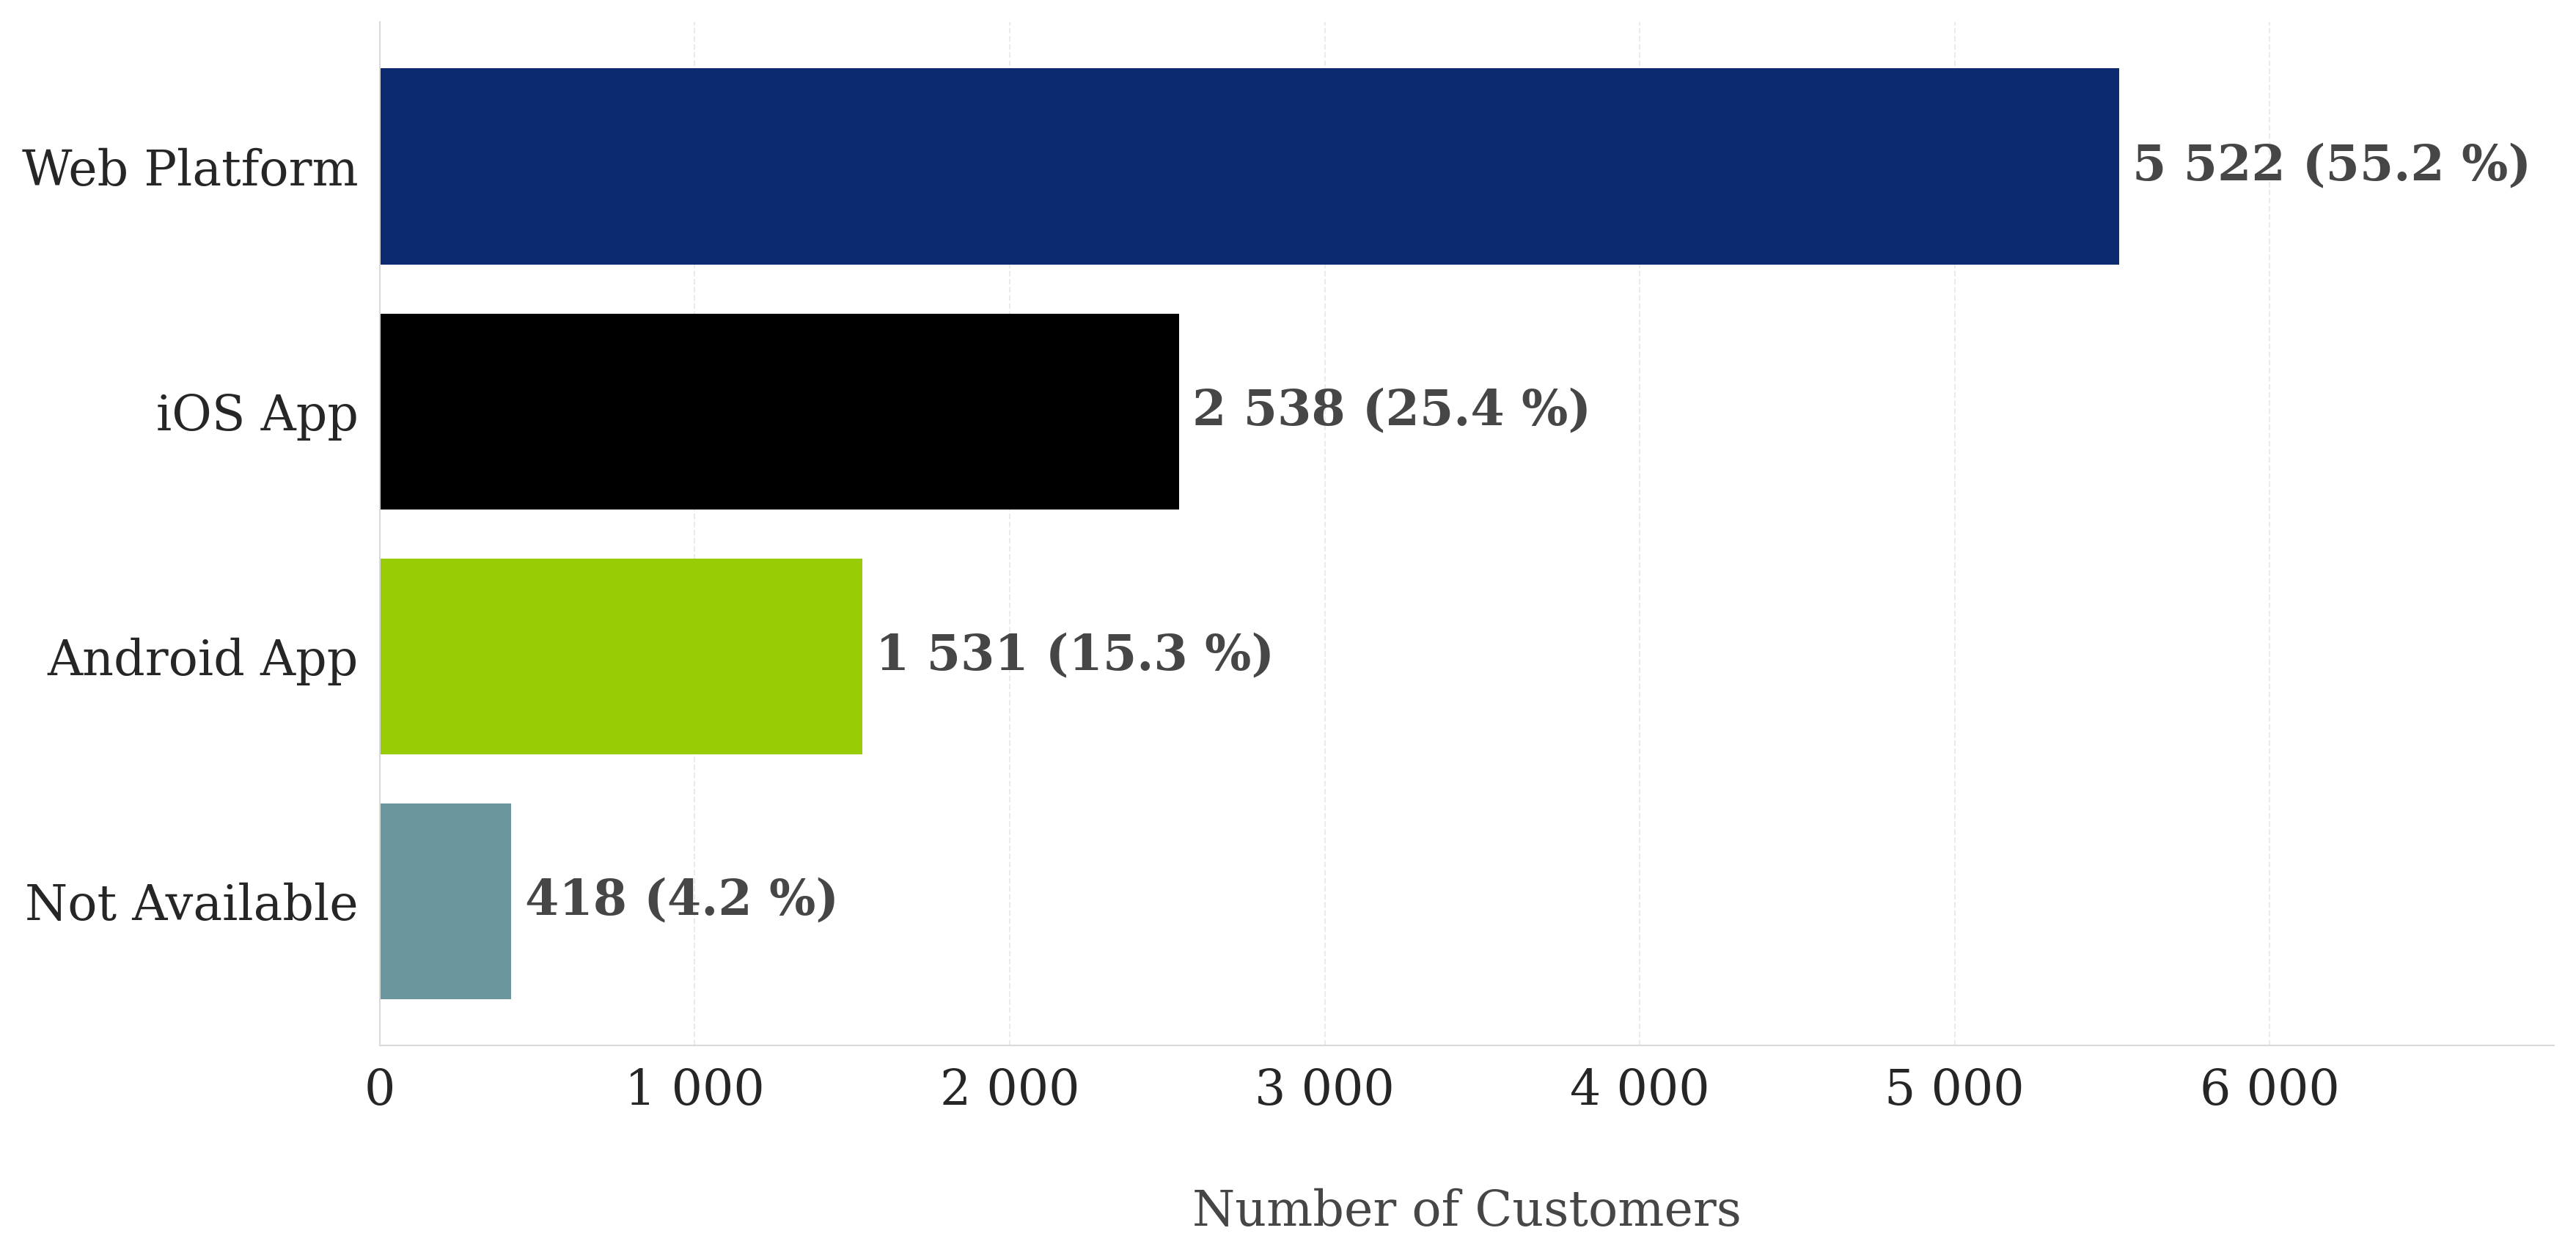

In [229]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read and prepare data
df = load_data("rq29-customer-app-usage.csv")
# Sort dataframe by count descending
df = df.sort_values('customer_count', ascending=False)

# Type mapping for better labels
category_config = {
	'Web': { 'color': get_chart_color(0), 'label': 'Web Platform' },
	'iOS': { 'color': '#000000', 'label': 'iOS App' },
	'Android': { 'color': get_chart_color(3), 'label': 'Android App' },
	'': { 'color': get_chart_color(2), 'label': 'Not Available' }
}


def get_config(row):
	return category_config[row['source']] if row['source'] in category_config else category_config['']


# Calculate total for percentages
total = df['customer_count'].sum()

# Create figure
fig, ax = plt.subplots(figsize=(12, 6))

# Create bars
bars = []
for i, (_, row) in enumerate(df[::-1].iterrows()):
	reversed_i = len(df) - i - 1  # Reverse order for better visualization
	bar = ax.barh(
		get_config(row)['label'],
		row['customer_count'],
		color=get_config(row)['color'],
	)
	bars.append(bar[0])

	# Add value labels
	width = row['customer_count']
	percentage = (width / total) * 100
	ax.text(
		width + 42,  # Slight padding
		bar[0].get_y() + bar[0].get_height() / 2,
		f"{format_number(width, 0)} ({format_percent(percentage)})",
		va='center',
		fontsize=16,
		color=get_chart_color('text'),
		fontweight='bold'
	)

# Customize chart
ax.set_xlabel('Number of Customers', fontsize=16, labelpad=24, color=get_chart_color('text'))
ax.tick_params(axis='both', labelsize=16)

# Format axis
ax.grid(True, axis='x', alpha=0.2)
ax.set_axisbelow(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# x-axis formatter
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format_number(x, 0)))

# Add padding to x-axis for labels
x_max = df['customer_count'].max()
ax.set_xlim(0, x_max * 1.25)

# hide grid y-axis
ax.grid(axis='y', linestyle='--', alpha=0)
ax.grid(axis='x', linestyle='--', alpha=0.5)

# Adjust layout
plt.tight_layout()

plt.savefig("./thesis/results/rq29-customer-app-ulime.png", dpi=300, bbox_inches='tight', pad_inches=0.1)

In [324]:
class BubbleChart:
	def __init__(self, area, bubble_spacing=0):
		"""
        Setup for bubble collapse.

        Parameters
        ----------
        area : array-like
            Area of the bubbles.
        bubble_spacing : float, default: 0
            Minimal spacing between bubbles after collapsing.

        Notes
        -----
        If "area" is sorted, the results might look weird.
        """
		area = np.asarray(area)
		r = np.sqrt(area / np.pi)

		self.bubble_spacing = bubble_spacing
		self.bubbles = np.ones((len(area), 4))
		self.bubbles[:, 2] = r
		self.bubbles[:, 3] = area
		self.maxstep = 2 * self.bubbles[:, 2].max() + self.bubble_spacing
		self.step_dist = self.maxstep / 2

		# calculate initial grid layout for bubbles
		length = np.ceil(np.sqrt(len(self.bubbles)))
		grid = np.arange(length) * self.maxstep
		gx, gy = np.meshgrid(grid, grid)
		self.bubbles[:, 0] = gx.flatten()[:len(self.bubbles)]
		self.bubbles[:, 1] = gy.flatten()[:len(self.bubbles)]

		self.com = self.center_of_mass()

	def center_of_mass(self):
		return np.average(
			self.bubbles[:, :2], axis=0, weights=self.bubbles[:, 3]
		)

	def center_distance(self, bubble, bubbles):
		return np.hypot(
			bubble[0] - bubbles[:, 0],
			bubble[1] - bubbles[:, 1]
		)

	def outline_distance(self, bubble, bubbles):
		center_distance = self.center_distance(bubble, bubbles)
		return center_distance - bubble[2] - \
			bubbles[:, 2] - self.bubble_spacing

	def check_collisions(self, bubble, bubbles):
		distance = self.outline_distance(bubble, bubbles)
		return len(distance[distance < 0])

	def collides_with(self, bubble, bubbles):
		distance = self.outline_distance(bubble, bubbles)
		return np.argmin(distance, keepdims=True)

	def collapse(self, n_iterations=50):
		"""
        Move bubbles to the center of mass.

        Parameters
        ----------
        n_iterations : int, default: 50
            Number of moves to perform.
        """
		for _i in range(n_iterations):
			moves = 0
			for i in range(len(self.bubbles)):
				rest_bub = np.delete(self.bubbles, i, 0)
				# try to move directly towards the center of mass
				# direction vector from bubble to the center of mass
				dir_vec = self.com - self.bubbles[i, :2]

				# shorten direction vector to have length of 1
				dir_vec = dir_vec / np.sqrt(dir_vec.dot(dir_vec))

				# calculate new bubble position
				new_point = self.bubbles[i, :2] + dir_vec * self.step_dist
				new_bubble = np.append(new_point, self.bubbles[i, 2:4])

				# check whether new bubble collides with other bubbles
				if not self.check_collisions(new_bubble, rest_bub):
					self.bubbles[i, :] = new_bubble
					self.com = self.center_of_mass()
					moves += 1
				else:
					# try to move around a bubble that you collide with
					# find colliding bubble
					for colliding in self.collides_with(new_bubble, rest_bub):
						# calculate direction vector
						dir_vec = rest_bub[colliding, :2] - self.bubbles[i, :2]
						dir_vec = dir_vec / np.sqrt(dir_vec.dot(dir_vec))
						# calculate orthogonal vector
						orth = np.array([dir_vec[1], -dir_vec[0]])
						# test which direction to go
						new_point1 = (self.bubbles[i, :2] + orth *
						              self.step_dist)
						new_point2 = (self.bubbles[i, :2] - orth *
						              self.step_dist)
						dist1 = self.center_distance(
							self.com, np.array([new_point1])
						)
						dist2 = self.center_distance(
							self.com, np.array([new_point2])
						)
						new_point = new_point1 if dist1 < dist2 else new_point2
						new_bubble = np.append(new_point, self.bubbles[i, 2:4])
						if not self.check_collisions(new_bubble, rest_bub):
							self.bubbles[i, :] = new_bubble
							self.com = self.center_of_mass()

			if moves / len(self.bubbles) < 0.1:
				self.step_dist = self.step_dist / 2

	def plot(self, ax, labels, colors):
		"""
        Draw the bubble plot.

        Parameters
        ----------
        ax : matplotlib.axes.Axes
        labels : list
            Labels of the bubbles.
        colors : list
            Colors of the bubbles.
        """
		for i in range(len(self.bubbles)):
			circ = plt.Circle(
				self.bubbles[i, :2], self.bubbles[i, 2], color=colors[i]
			)
			ax.add_patch(circ)

# ax.text(
#     *self.bubbles[i, :2], labels[i],
#     horizontalalignment='center', verticalalignment='center',
#     fontsize=14
# )

/var/folders/c3/2hv96b893plc4w_ptghflx840000gn/T/ipykernel_27354/1268446147.py:6: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



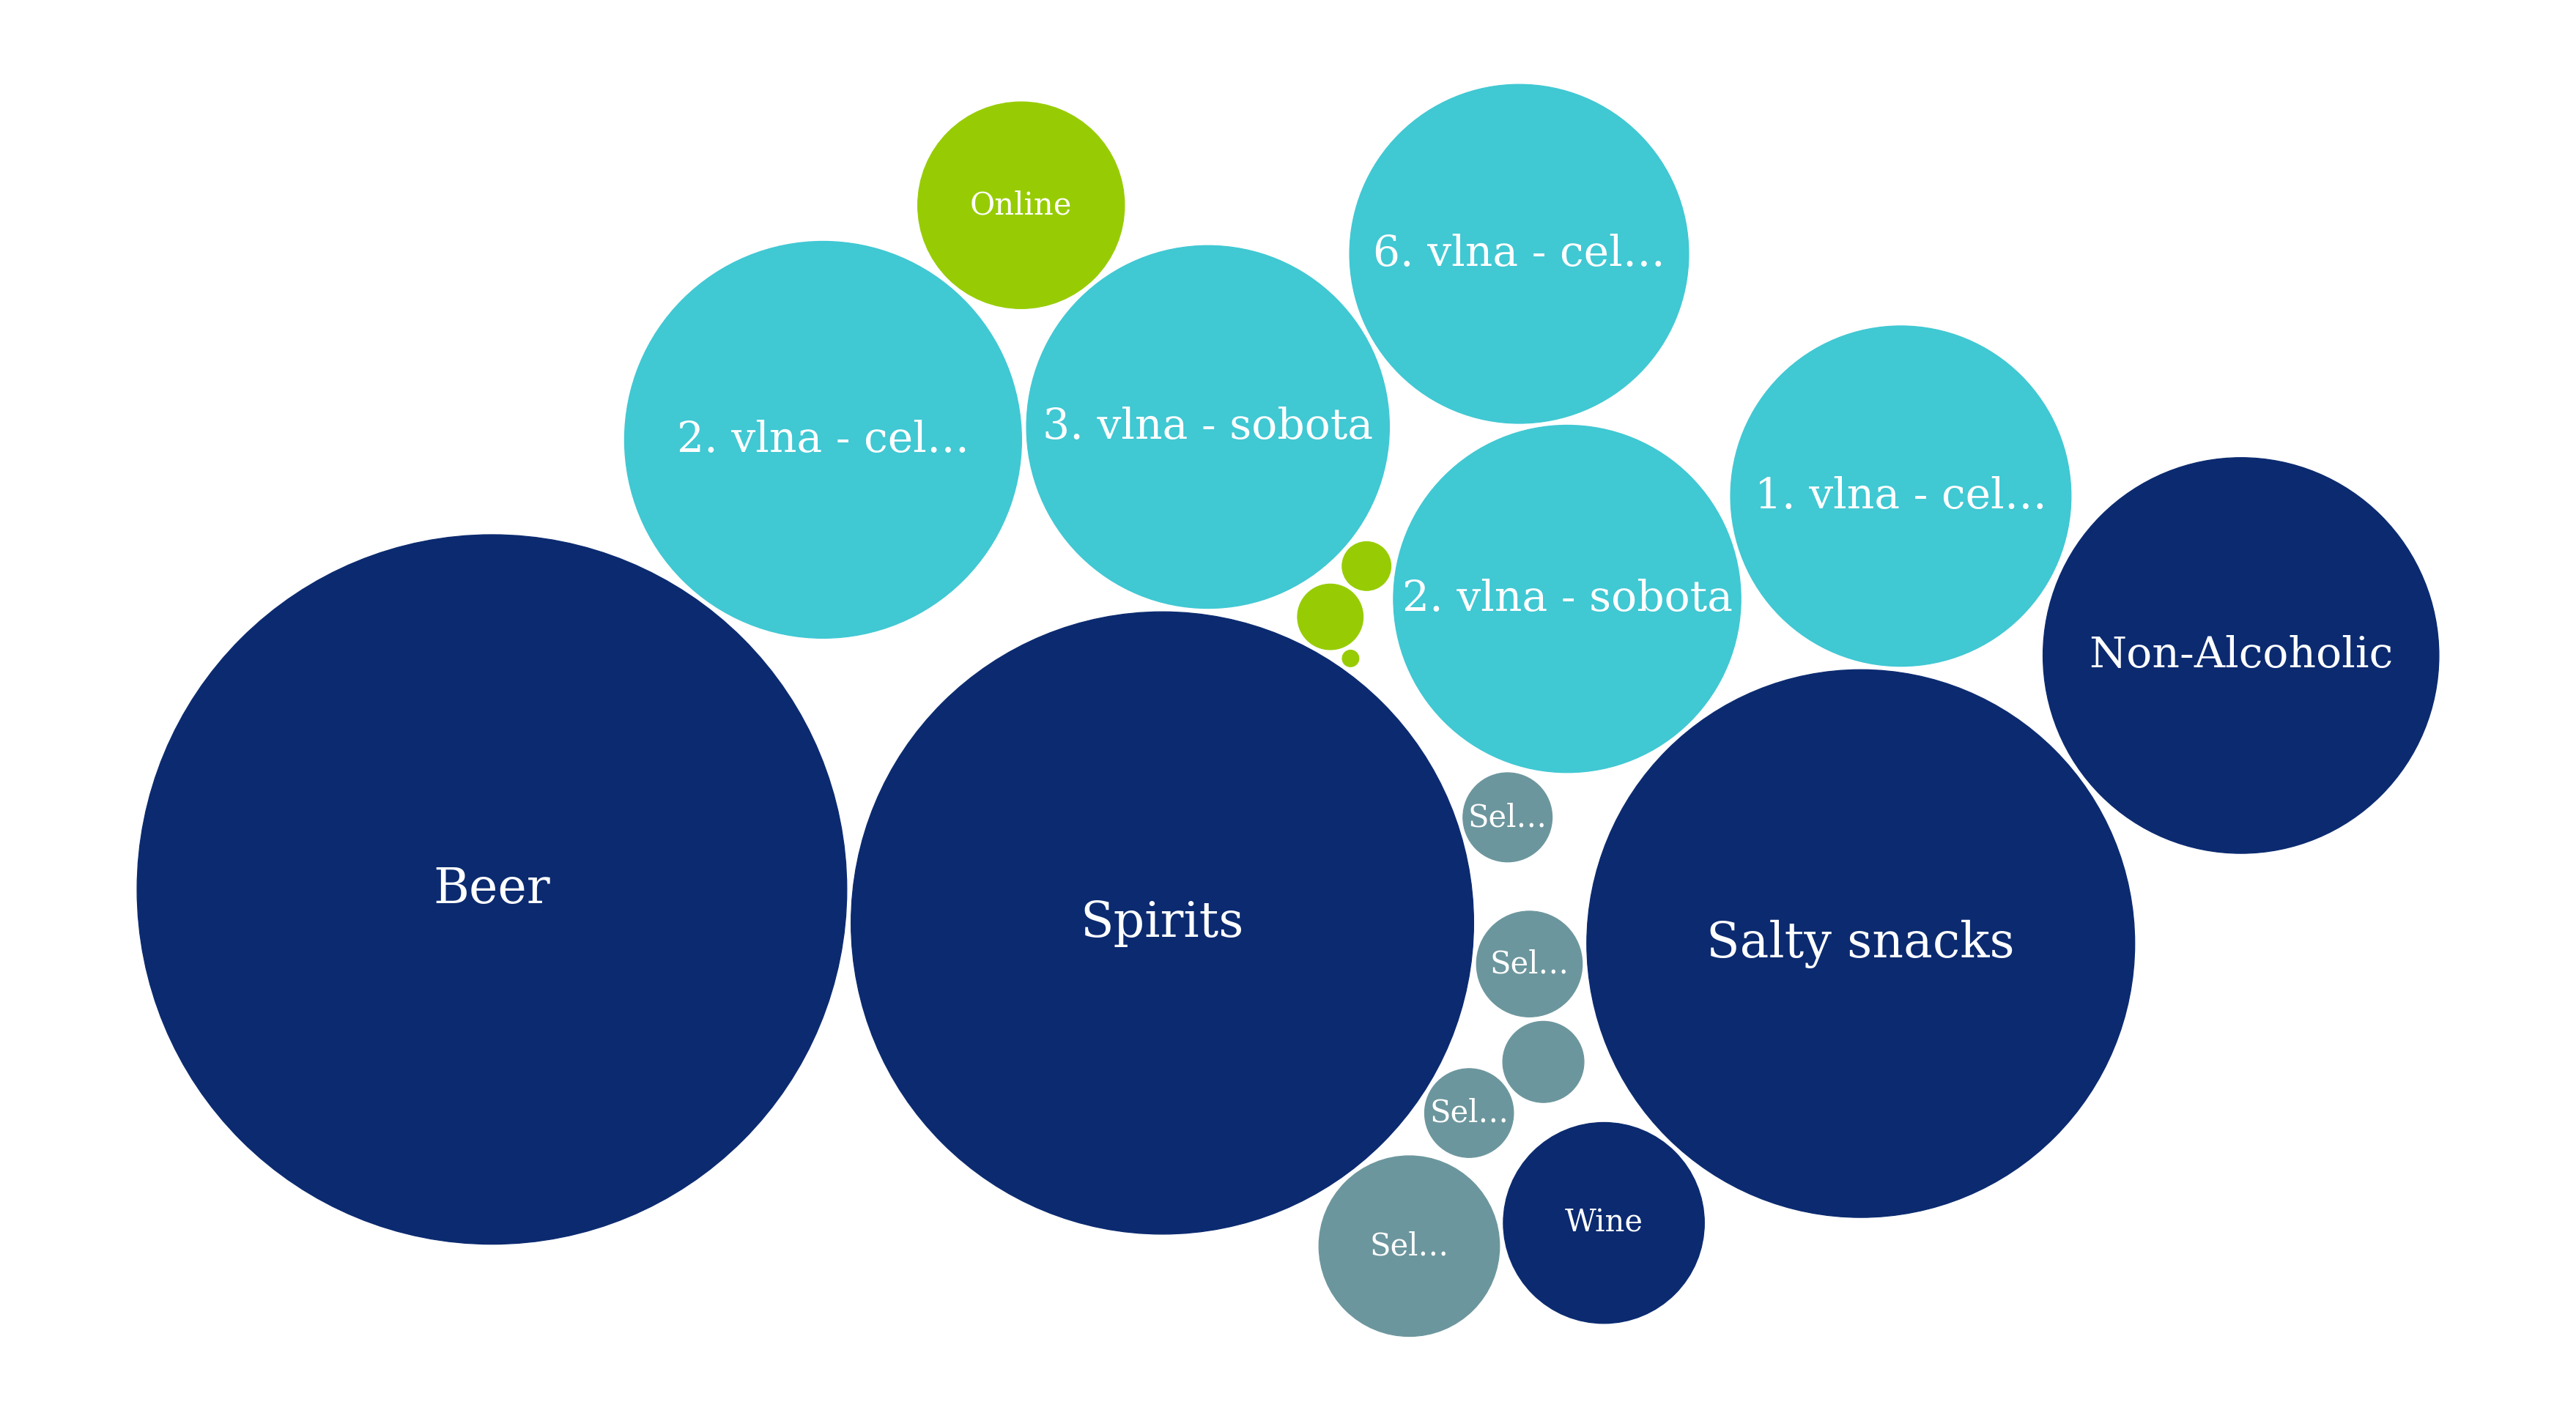

In [351]:
import matplotlib.pyplot as plt
import numpy as np

# Define your data
df = load_data("rq1-total-revenue-breakdown.csv")
grouped_data = df.groupby('grouped').apply(lambda g: g.nlargest(5, 'value', 'all')).reset_index(drop=True)

# Normalize Sizes for Bubble Chart
max_bubble_size = 15000  # Adjust for scaling
max_value = grouped_data['value'].max()
grouped_data['size'] = grouped_data['value'] / max_value * max_bubble_size

# Define colors for each bubble
grouped_colors = {
	"commission": get_chart_color(2),
	"unclaimed_balance": get_chart_color(3),
	"ticket_sales": get_chart_color(1),
	"direct_sales": get_chart_color(0),
}
colors = [grouped_colors[group] for group in grouped_data['grouped']]


# Function to truncate labels
def truncate_label(label, max_length=16):
	if len(label) > max_length:
		return label[:max_length - 3] + "…"
	return label


# Adjust labels based on bubble size
labels = []
for _, row in grouped_data.iterrows():
	size = row['size']
	category = row['category']
	labels.append("")

# Load data and process it
bubble_chart = BubbleChart(grouped_data['size'], bubble_spacing=1)
bubble_chart.collapse()

# Plot the chart
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw=dict(aspect="equal"))
bubble_chart.plot(ax, labels, colors)

# Add labels manually
for i, (x, y, r) in enumerate(bubble_chart.bubbles[:, :3]):
	size = grouped_data.loc[i, 'size']
	category = grouped_data.loc[i, 'category']

	# Determine label visibility and text
	if size > 3000:  # Larger bubbles show full labels
		label = truncate_label(category, max_length=16)
		font_size = 16 if size > 5000 else 14  # Adjust font size based on bubble size
		ax.text(
			x, y, label,
			ha="center", va="center",
			fontsize=font_size, fontname="serif", color="white"
		)
	elif size > 1000:  # Medium bubbles show truncated labels
		label = truncate_label(category, max_length=8)
		ax.text(
			x, y, label,
			ha="center", va="center",
			fontsize=10, fontname="serif", color="white"
		)
	elif size > 200:
		label = truncate_label(category, max_length=6)
		ax.text(
			x, y, label,
			ha="center", va="center",
			fontsize=10, fontname="serif", color="white"
		)

# Styling
ax.axis('off')  # Hide axes
ax.relim()
ax.autoscale_view()
plt.tight_layout()

plt.savefig("./thesis/results/rq1-total-revenue-breakdown.png", dpi=300, bbox_inches='tight', pad_inches=0.1)

/var/folders/c3/2hv96b893plc4w_ptghflx840000gn/T/ipykernel_42218/3054079176.py:62: UserWarning:

FixedFormatter should only be used together with FixedLocator



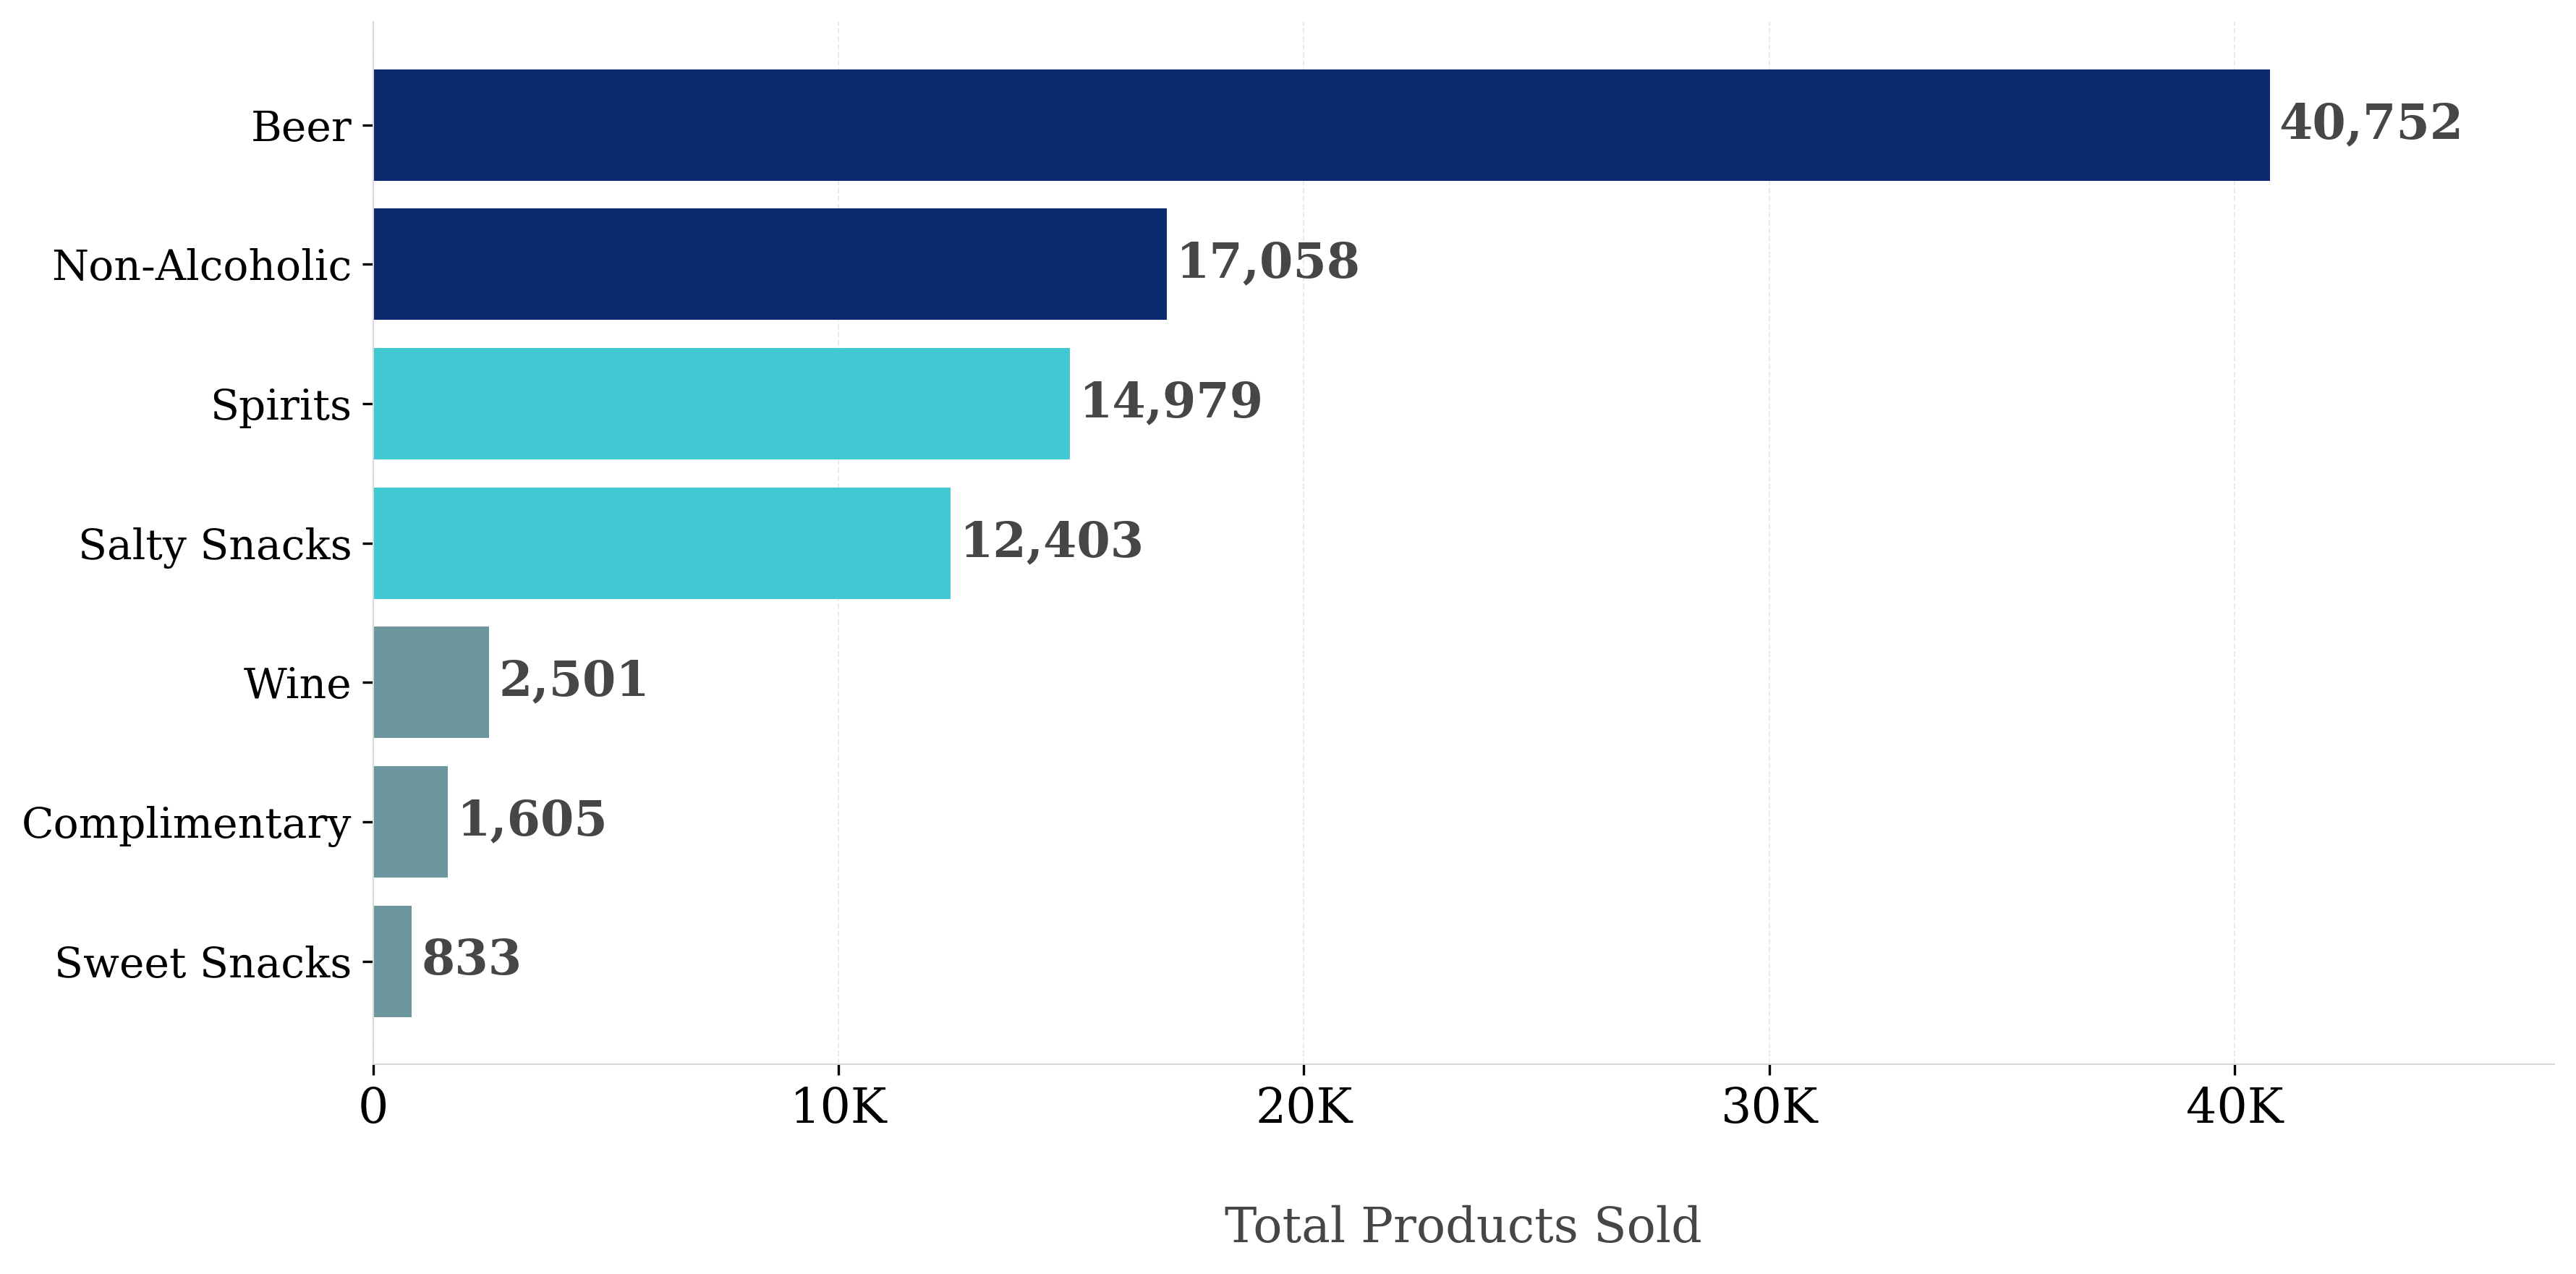

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read and prepare data
df = load_data("rq11-best-product-category.csv")

# Group by category and calculate mean sales
category_sales = df.groupby('category')['sales_count'].mean().sort_values(ascending=True)

# Create figure
fig, ax = plt.subplots(figsize=(12, 6))

# Type mapping for better labels
category_config = {
	# 'Web': { 'color': get_chart_color(0), 'label': 'Web Platform' },
	'Beer': { 'color': get_chart_color(0) },
	'Spirits': { 'color': get_chart_color(1) },
	'Wine': { 'color': get_chart_color(2) },
	'Non-Alcoholic': { 'color': get_chart_color(0) },
	'Salty Snacks': { 'color': get_chart_color(1) },
	'Sweet Snacks': { 'color': get_chart_color(2) },
	'Complimentary': { 'color': get_chart_color(2) },
}

# Create horizontal bars
bars = []
for i, (cat, value) in enumerate(category_sales.items()):
	conf = category_config[cat]
	bar = ax.barh(
		cat,
		value,
		color=conf['color']
	)
	bars.append(bar[0])

	# Add value labels
	ax.text(
		value + 200,  # Slight padding
		bar[0].get_y() + bar[0].get_height() / 2,
		f'{int(value):,}',
		va='center',
		fontsize=16,
		color=get_chart_color('text'),
		fontweight='bold'
	)

# Customize chart
ax.set_xlabel('Total Products Sold', fontsize=16, labelpad=24, color=get_chart_color('text'))
ax.tick_params(axis='both', labelsize=16)

# x-tick formatter
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: format_number_short(x)))

# Format axis
ax.grid(True, axis='x', alpha=0.2)
ax.set_axisbelow(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Format y-axis labels
ax.set_yticklabels(category_sales.index, fontsize=14)

# Add padding to x-axis for labels
x_max = category_sales.max()
ax.set_xlim(0, x_max * 1.15)  # Add 15% padding for labels

# hide grid y-axis
ax.grid(axis='y', linestyle='--', alpha=0)
ax.grid(axis='x', linestyle='--', alpha=0.5)

# Adjust layout
plt.tight_layout()

plt.savefig("./thesis/results/rq11-best-product-category.png", dpi=300, bbox_inches='tight', pad_inches=0.1)

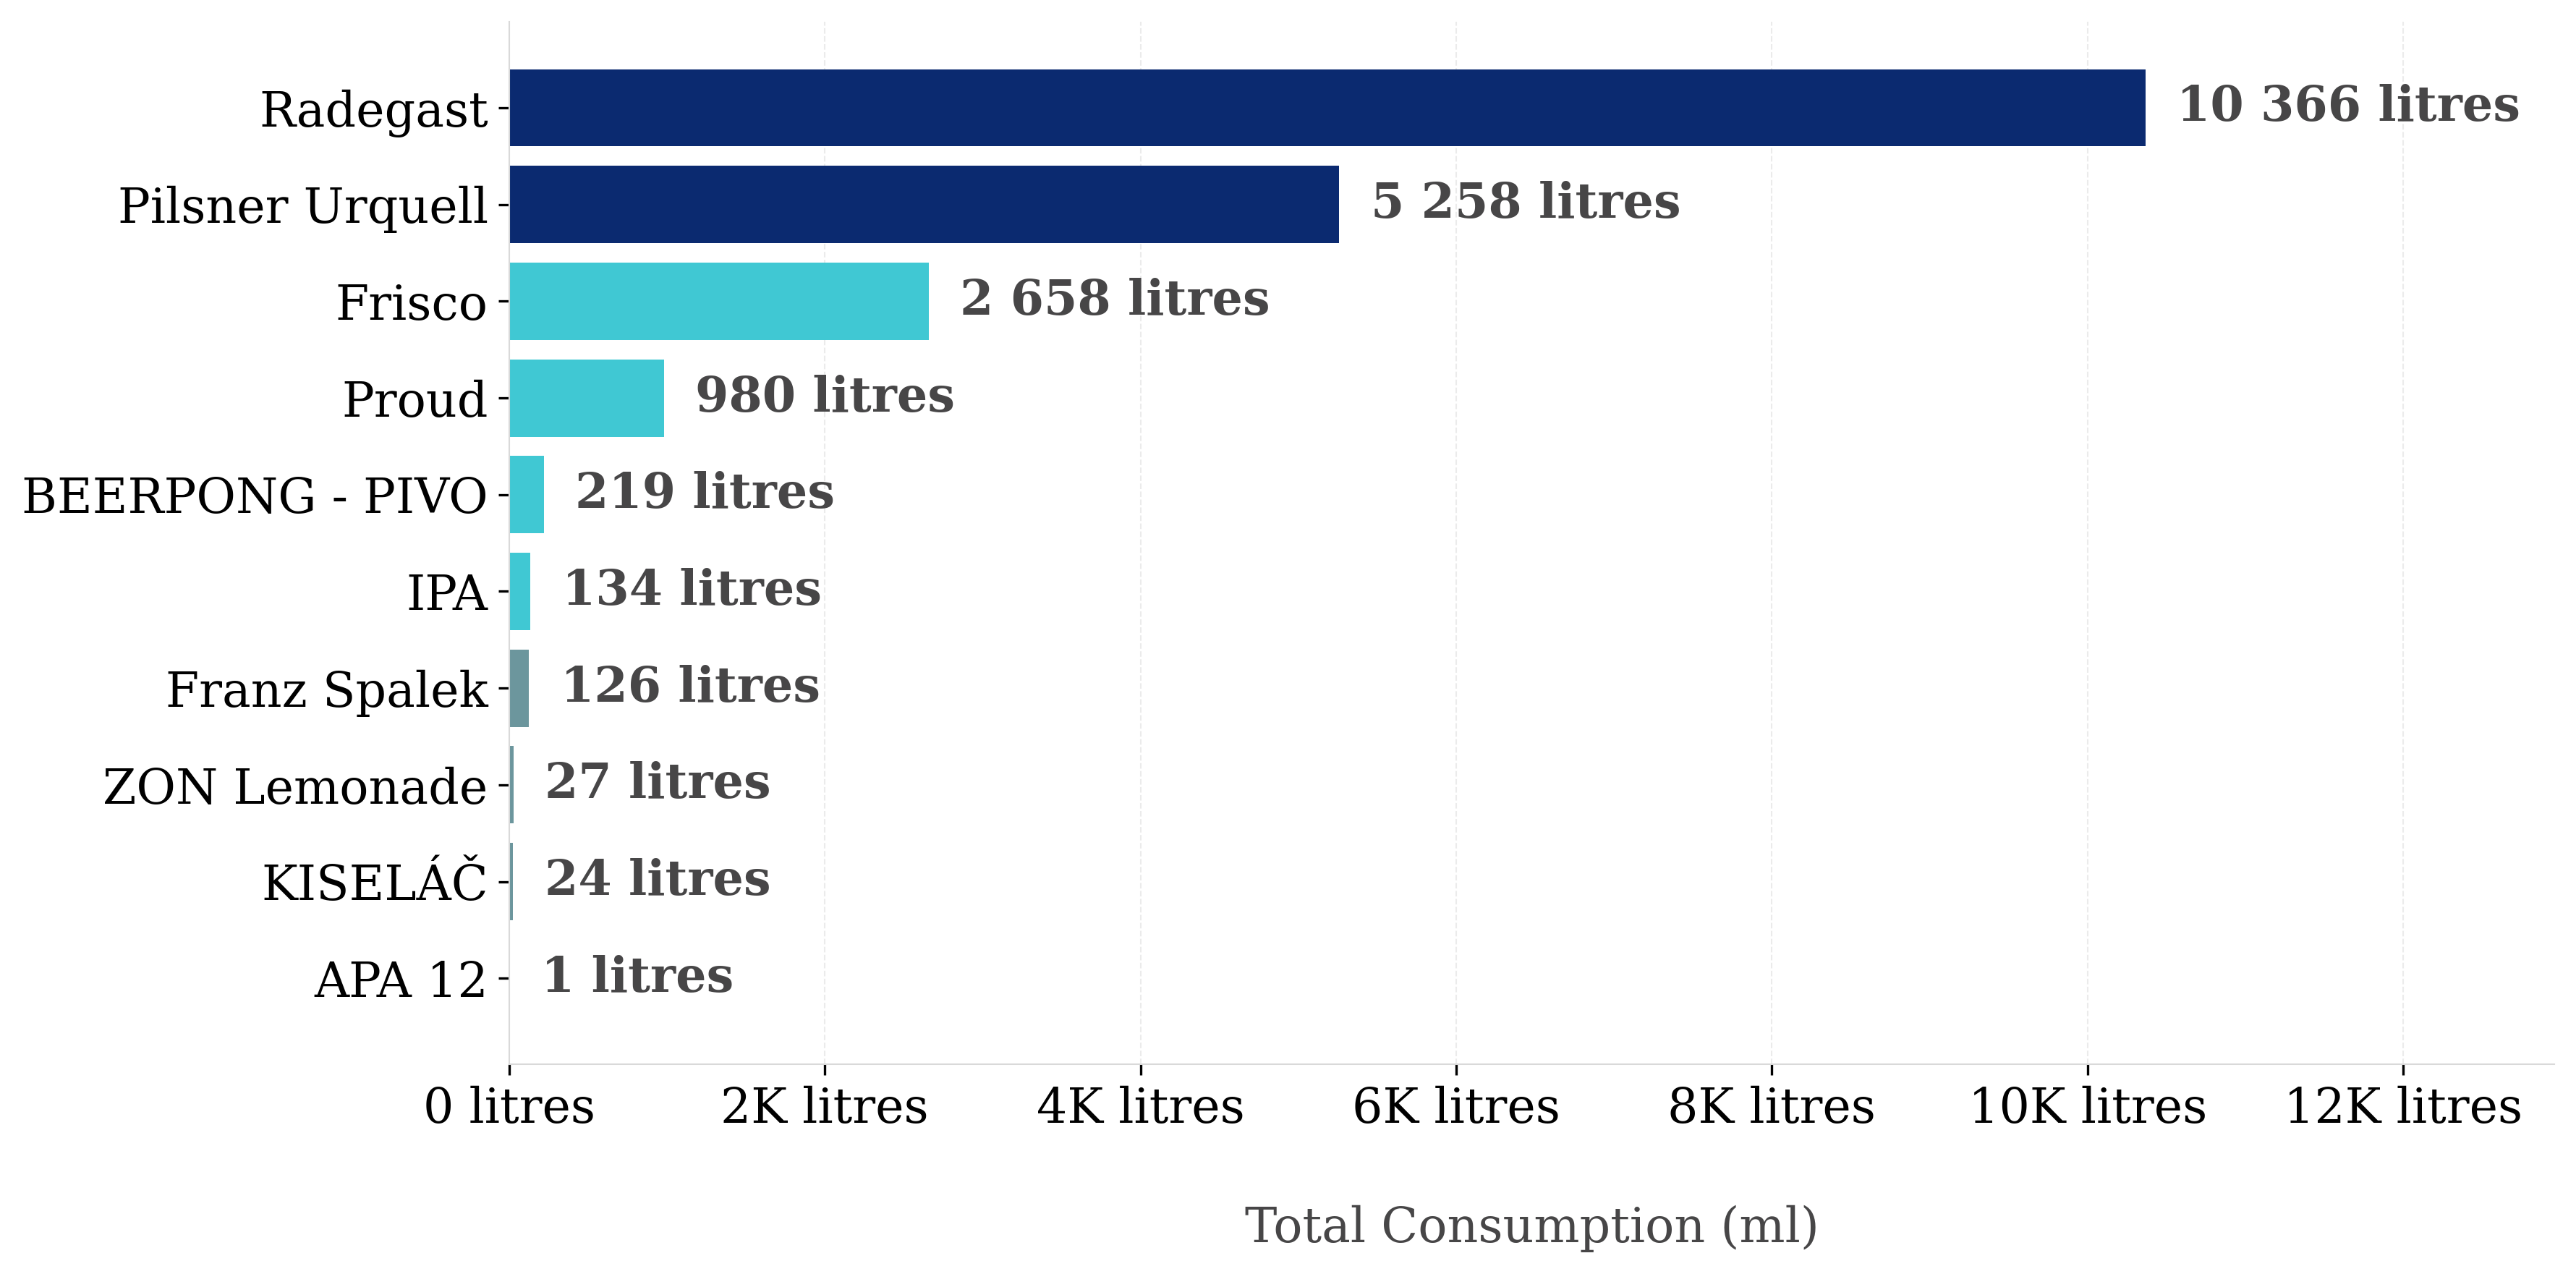

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import ticker

# Read and prepare data
df = load_data("rq15-top-beer-brands.csv")
# Sort by consumption
df = df.sort_values('total_consumption_ml', ascending=True)

# Create figure
fig, ax = plt.subplots(figsize=(12, 6))

# Create horizontal bars
bars = []
for i, row in df.iterrows():
	colors = [0, 0, 1, 1, 1, 1]
	bar = ax.barh(
		row['subcategory'],
		row['total_consumption_ml'],
		color=get_chart_color(colors[i] if i < len(colors) else 2),
	)
	bars.append(bar[0])

	# Add value labels
	ax.text(
		row['total_consumption_ml'] + 200,  # Slight padding
		bar[0].get_y() + bar[0].get_height() / 2,
		format_volume(row["total_consumption_ml"] * 1000),
		va='center',
		fontsize=16,
		color=get_chart_color('text'),
		fontweight='bold'
	)

# Customize chart
ax.set_xlabel('Total Consumption (ml)', fontsize=16, labelpad=24, color=get_chart_color('text'))
ax.tick_params(axis='both', labelsize=16)

# x-tick formatter
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{format_number_short(x)} litres"))

# Format axis
ax.grid(True, axis='x', alpha=0.2)
ax.set_axisbelow(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add padding to x-axis for labels
x_max = df['total_consumption_ml'].max()
ax.set_xlim(0, x_max * 1.25)  # Add 15% padding for labels

# hide grid y-axis
ax.grid(axis='y', linestyle='--', alpha=0)
ax.grid(axis='x', linestyle='--', alpha=0.5)

# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig("./thesis/results/rq15-top-beer-brands.png", dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()